In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import matplotlib.colors
colors_land = plt.cm.terrain(np.linspace(0.25, 1, 256))
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy.stats import chi2
from numba import njit,prange
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.05  # previous pdf hatch linewidth
from matplotlib.dates import DateFormatter

from scipy.stats import linregress
from scipy import interpolate

from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [2]:
normal_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':True, 'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}
multiplot_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':False, 'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}

imin = 32 ; imax = -30
jmin = 20 ; jmax = -15
ds = xr.open_dataset('/bettik/beaumetj/MARout/MAR-ERA-20C/MARgrid_EUf.nc')
lon = ds.LON[jmin:jmax,imin:imax]
lat = ds.LAT[jmin:jmax,imin:imax]
H = np.array(ds.SH[jmin:jmax,imin:imax])

In [3]:
def detect_alps(H):
    nlat,nlon = np.shape(H)
    mask = np.bool_(np.zeros((nlat,nlon)))
    r = 4
    for j in range(r,nlat-r):
        for i in range(r,nlon-r):
            mask[j,i] = np.logical_and(H[j,i]>360 ,np.any(H[j-r:j+r,i-r:i+r]>1300))
            # mask[j,i] = np.std(H[j-r:j+r,i-r:i+r])>200
    return mask
alps = detect_alps(H)
alps[lon<4.8] = False
alps[np.logical_and(lon>10,lat<45.2)] = False


ne_alps = np.copy(alps) # ne : north-east
ne_alps[lat<46.7] = False


nw_alps2 = np.copy(alps) # nw : north-west
nw_alps2[lon>7.9] = False
nw_alps2[lat<45.9] = False
nw_alps2[lat>46.7] = False

nw_alps3 = np.copy(alps) # nw : north-west
nw_alps3[lon>6.9] = False
nw_alps3[lat<44.8] = False
nw_alps3[lat>46.7] = False

nw_alps4 = np.copy(alps) # nw : north-west
nw_alps4[lon>8.3] = False
nw_alps4[lat<46.4] = False
nw_alps4[lat>46.7] = False

nw_alps5 = np.copy(alps) # nw : north-west
nw_alps5[lon>7.1] = False
nw_alps5[lat<45.2] = False
nw_alps5[lat>46.7] = False

nw_alps = np.logical_or(np.logical_or(np.logical_or(nw_alps2,nw_alps3),nw_alps4),nw_alps5)


s_alps = np.logical_and(alps,np.invert(np.logical_or(nw_alps,ne_alps)))

In [4]:
region_masks = [alps,ne_alps,nw_alps,s_alps]
names_regions = ['Alps','Alps NE','Alps NW','Alps S']

In [5]:
def spline(knots, x, y):
    x_new = np.linspace(0, 1, knots+2)[1:-1]
    q_knots = np.quantile(x, x_new)
    t, c, k = interpolate.splrep(x, y, t=q_knots)
    yfit = interpolate.BSpline(t,c, k)(x)
    return yfit

In [6]:
wp_meanseason_meanT = np.load('/bettik/castelli/data/saved_data_MAR_ECEarth3/wp_meanseason_meanT.npy')[:,:,jmin:jmax,imin:imax]

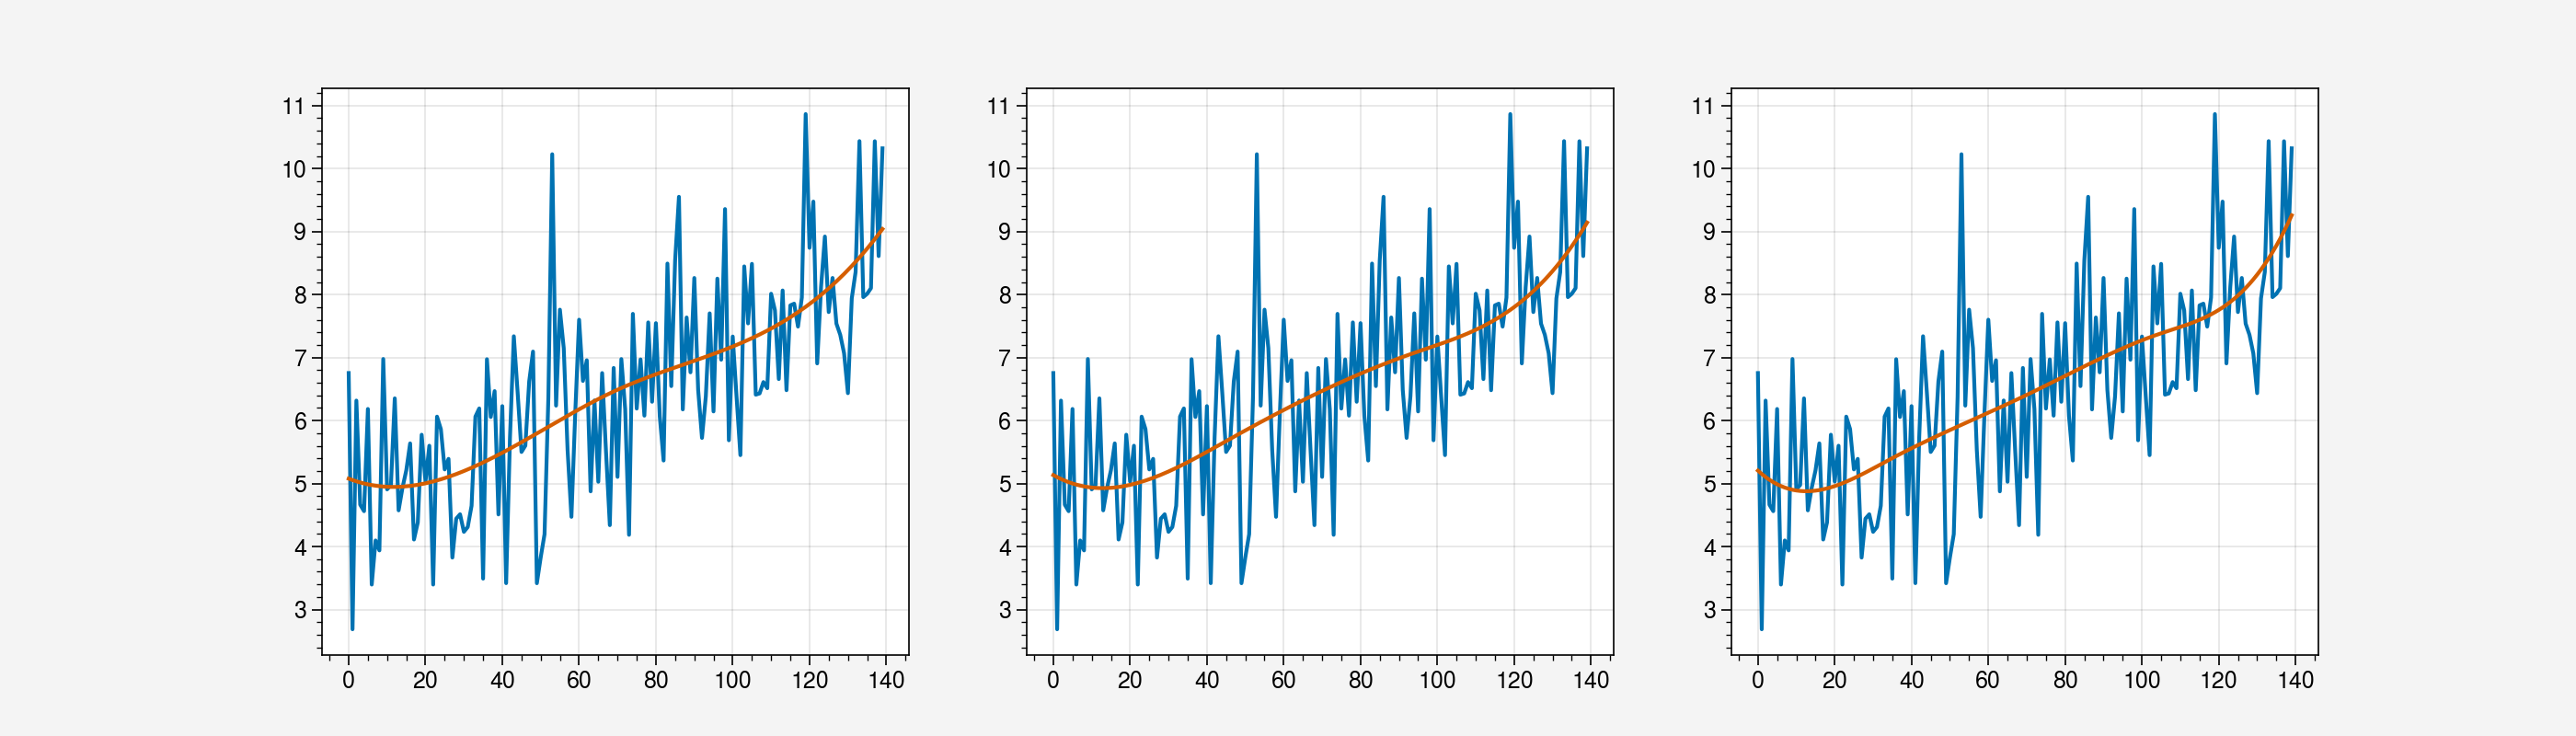

In [7]:
ig, ax = plt.subplots(ncols=3, figsize=(14, 4))

loc1 = 50
loc2 = 60
seas = 1

ax[0].plot(wp_meanseason_meanT[:,seas,loc1,loc2])
ax[1].plot(wp_meanseason_meanT[:,seas,loc1,loc2])
ax[2].plot(wp_meanseason_meanT[:,seas,loc1,loc2])

yfit = spline(1,np.arange(0,140,1),wp_meanseason_meanT[:,seas,loc1,loc2])
ax[0].plot(yfit)

yfit = spline(2,np.arange(0,140,1),wp_meanseason_meanT[:,seas,loc1,loc2])
ax[1].plot(yfit)

yfit = spline(3,np.arange(0,140,1),wp_meanseason_meanT[:,seas,loc1,loc2])
ax[2].plot(yfit)

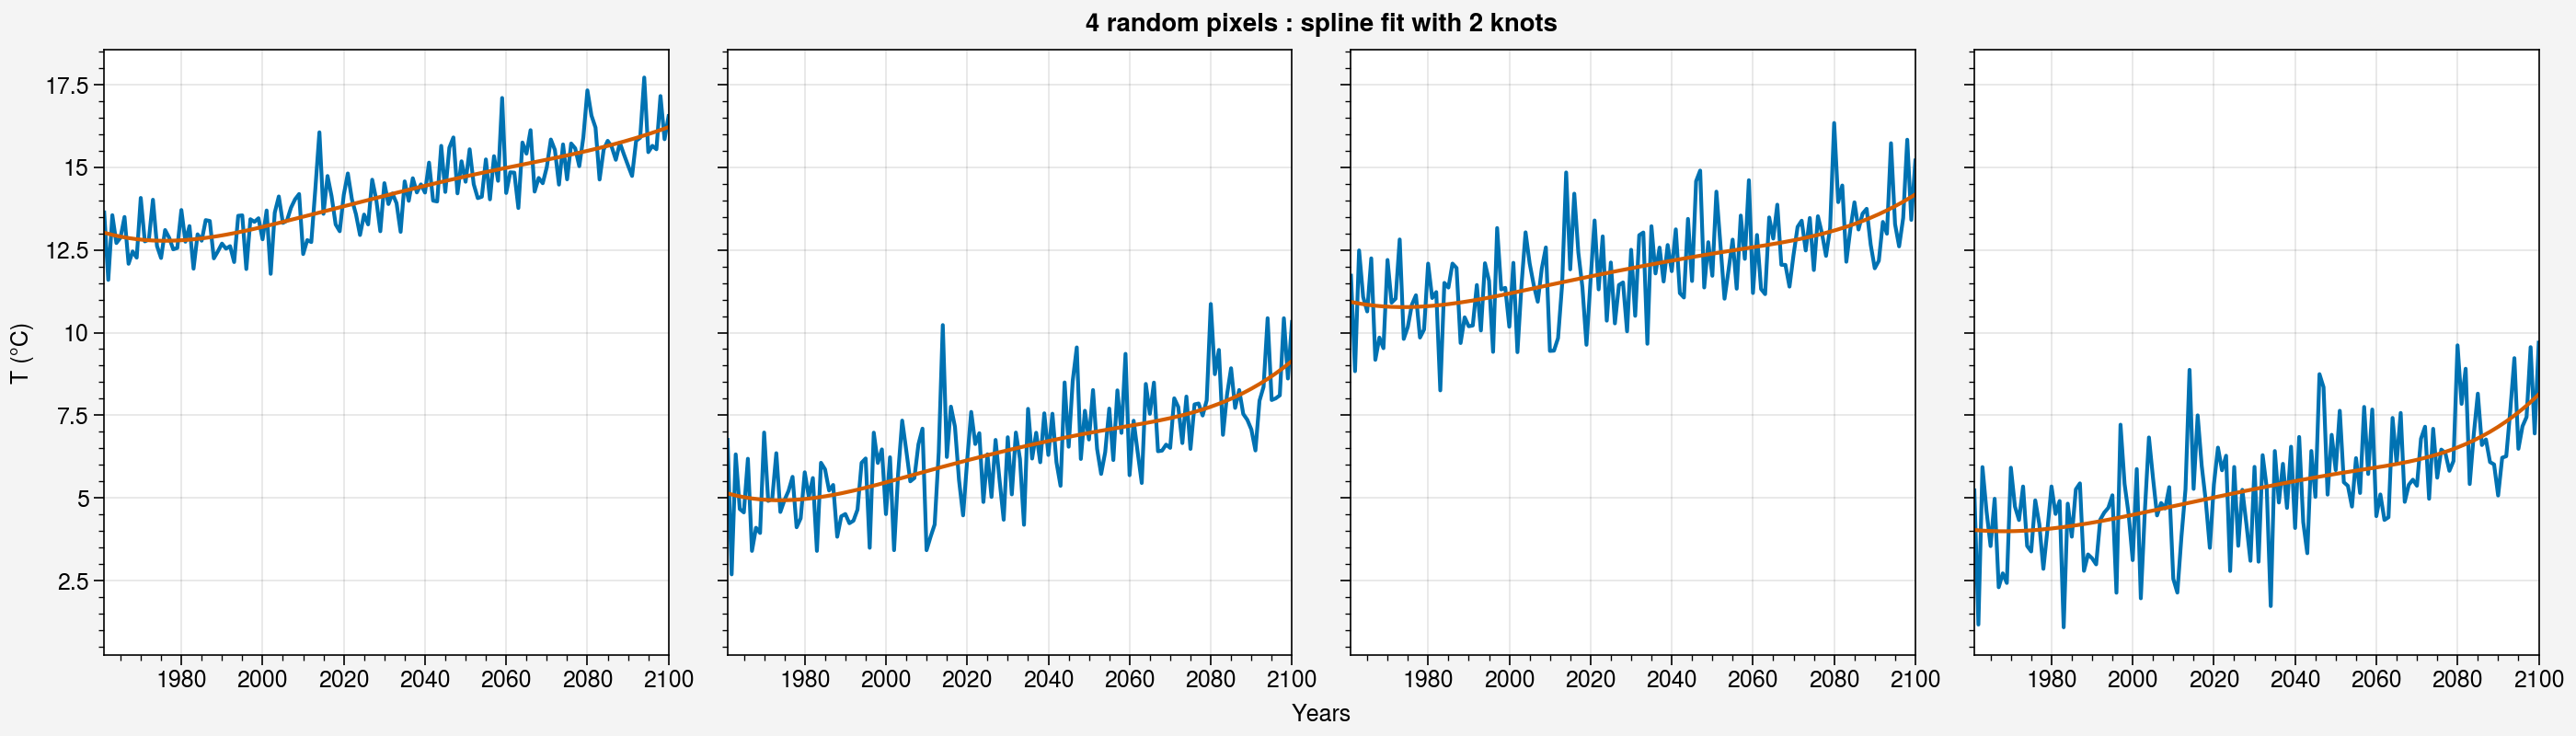

In [8]:
f, ax = pplt.subplots(ncols=4, figsize=(14, 4))

loc1 = [10,50,60,70]
loc2 = [40,60,20,90]
seas = 1
knots = 2

for i in range(4):
    ax[i].plot(np.arange(1961,2101,1),wp_meanseason_meanT[:,seas,loc1[i],loc2[i]])
    yfit = spline(knots,np.arange(0,140,1),wp_meanseason_meanT[:,seas,loc1[i],loc2[i]])
    ax[i].plot(np.arange(1961,2101,1),yfit)

f.format(suptitle='4 random pixels : spline fit with 2 knots',xlabel='Years',ylabel='T (°C)')

In [9]:
wp_meanseason_meanT_spfit_2k = np.zeros(wp_meanseason_meanT.shape)

for seas in range(4):
    for i in range(91):
        for j in range(139):
            yfit = spline(knots=2,x=np.arange(0,140,1),y=wp_meanseason_meanT[:,seas,i,j])
            wp_meanseason_meanT_spfit_2k[:,seas,i,j] = yfit

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 

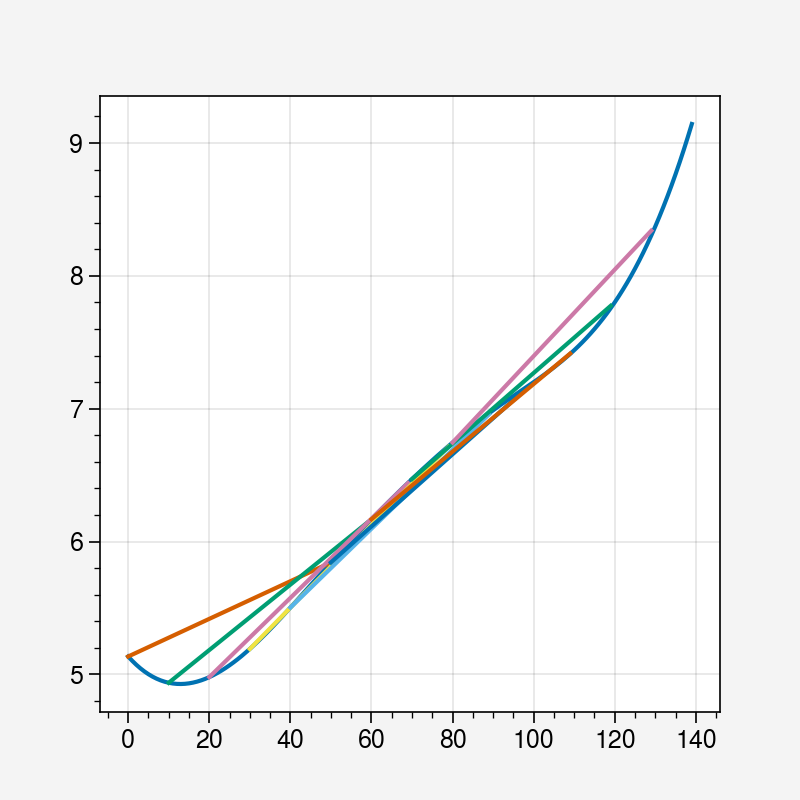

In [10]:
plt.plot(wp_meanseason_meanT_spfit_2k[:,1,50,60])

l = 50 # length of periods

n = 140-l # number of periods

slope_T_periods=np.full(n,np.nan)

for year in np.arange(0,n):
    print(year,end=' ')
    endyear = year+l
    slope_T_periods[year] = (wp_meanseason_meanT_spfit_2k[endyear,1,50,60] - wp_meanseason_meanT_spfit_2k[year,1,50,60])/l
    
    if year%10 == 0:
        x = np.arange(year,endyear,1)
        origin = wp_meanseason_meanT_spfit_2k[endyear,1,50,60] - slope_T_periods[year]*endyear
        plt.plot(x,slope_T_periods[year]*x+origin)

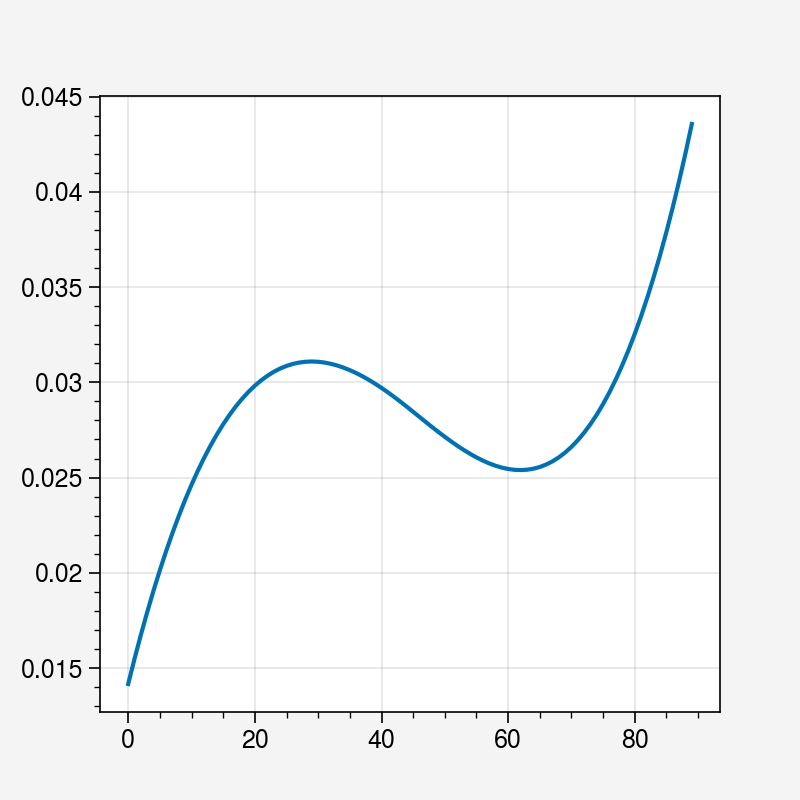

In [11]:
plt.plot(slope_T_periods)

In [12]:
wp_meanseason_meanT_hist = wp_meanseason_meanT_spfit_2k[:54,:,:,:]
wp_meanseason_meanT_fut = wp_meanseason_meanT_spfit_2k[55:,:,:,:]

origin_T_hist=np.full(wp_meanseason_meanT_hist.shape[1:4],np.nan)
slope_T_hist=np.full(wp_meanseason_meanT_hist.shape[1:4],np.nan)

origin_T_fut=np.full(wp_meanseason_meanT_fut.shape[1:4],np.nan)
slope_T_fut=np.full(wp_meanseason_meanT_fut.shape[1:4],np.nan)

for i in range(wp_meanseason_meanT_spfit_2k.shape[3]):
    # print(str(lon)+'/'+str(les_season_maxT.shape[3]),end=' ')
    for j in range(wp_meanseason_meanT_spfit_2k.shape[2]):
        for season in range(4):
            slope_T_hist[season][j][i] = (wp_meanseason_meanT_hist[-1,season,j,i] - wp_meanseason_meanT_hist[0,season,j,i])/wp_meanseason_meanT_hist.shape[0]
            origin_T_hist[season][j][i] = wp_meanseason_meanT_hist[-1,season,j,i] - slope_T_hist[season][j][i]*(wp_meanseason_meanT_hist.shape[0]-1)
            
            slope_T_fut[season][j][i] = (wp_meanseason_meanT_fut[-1,season,j,i] - wp_meanseason_meanT_fut[0,season,j,i])/wp_meanseason_meanT_fut.shape[0]
            origin_T_fut[season][j][i] = wp_meanseason_meanT_fut[-1,season,j,i] - slope_T_fut[season][j][i]*(140-1)

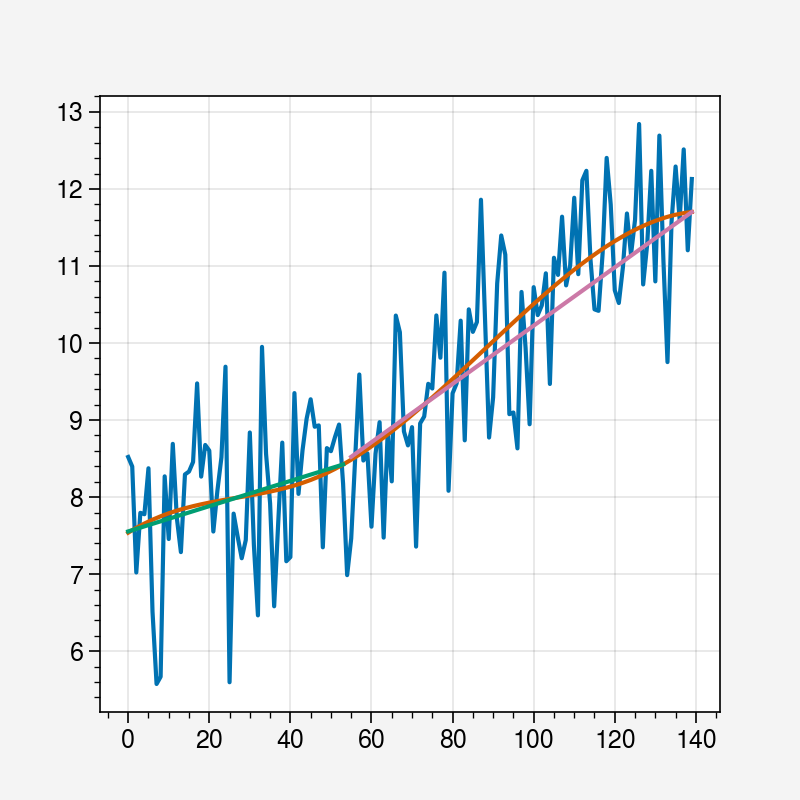

In [13]:
loc1 = 50
loc2 = 60
seas = 3

plt.plot(wp_meanseason_meanT[:,seas,loc1,loc2])
plt.plot(wp_meanseason_meanT_spfit_2k[:,seas,loc1,loc2])
plt.plot(np.arange(0,54,1),slope_T_hist[seas,loc1,loc2]*np.arange(0,54,1) + origin_T_hist[seas,loc1,loc2])
plt.plot(np.arange(55,140,1),slope_T_fut[seas,loc1,loc2]*np.arange(55,140,1) + origin_T_fut[seas,loc1,loc2])

In [14]:
origin_T_fut[seas,loc1,loc2]

6.443427147970076

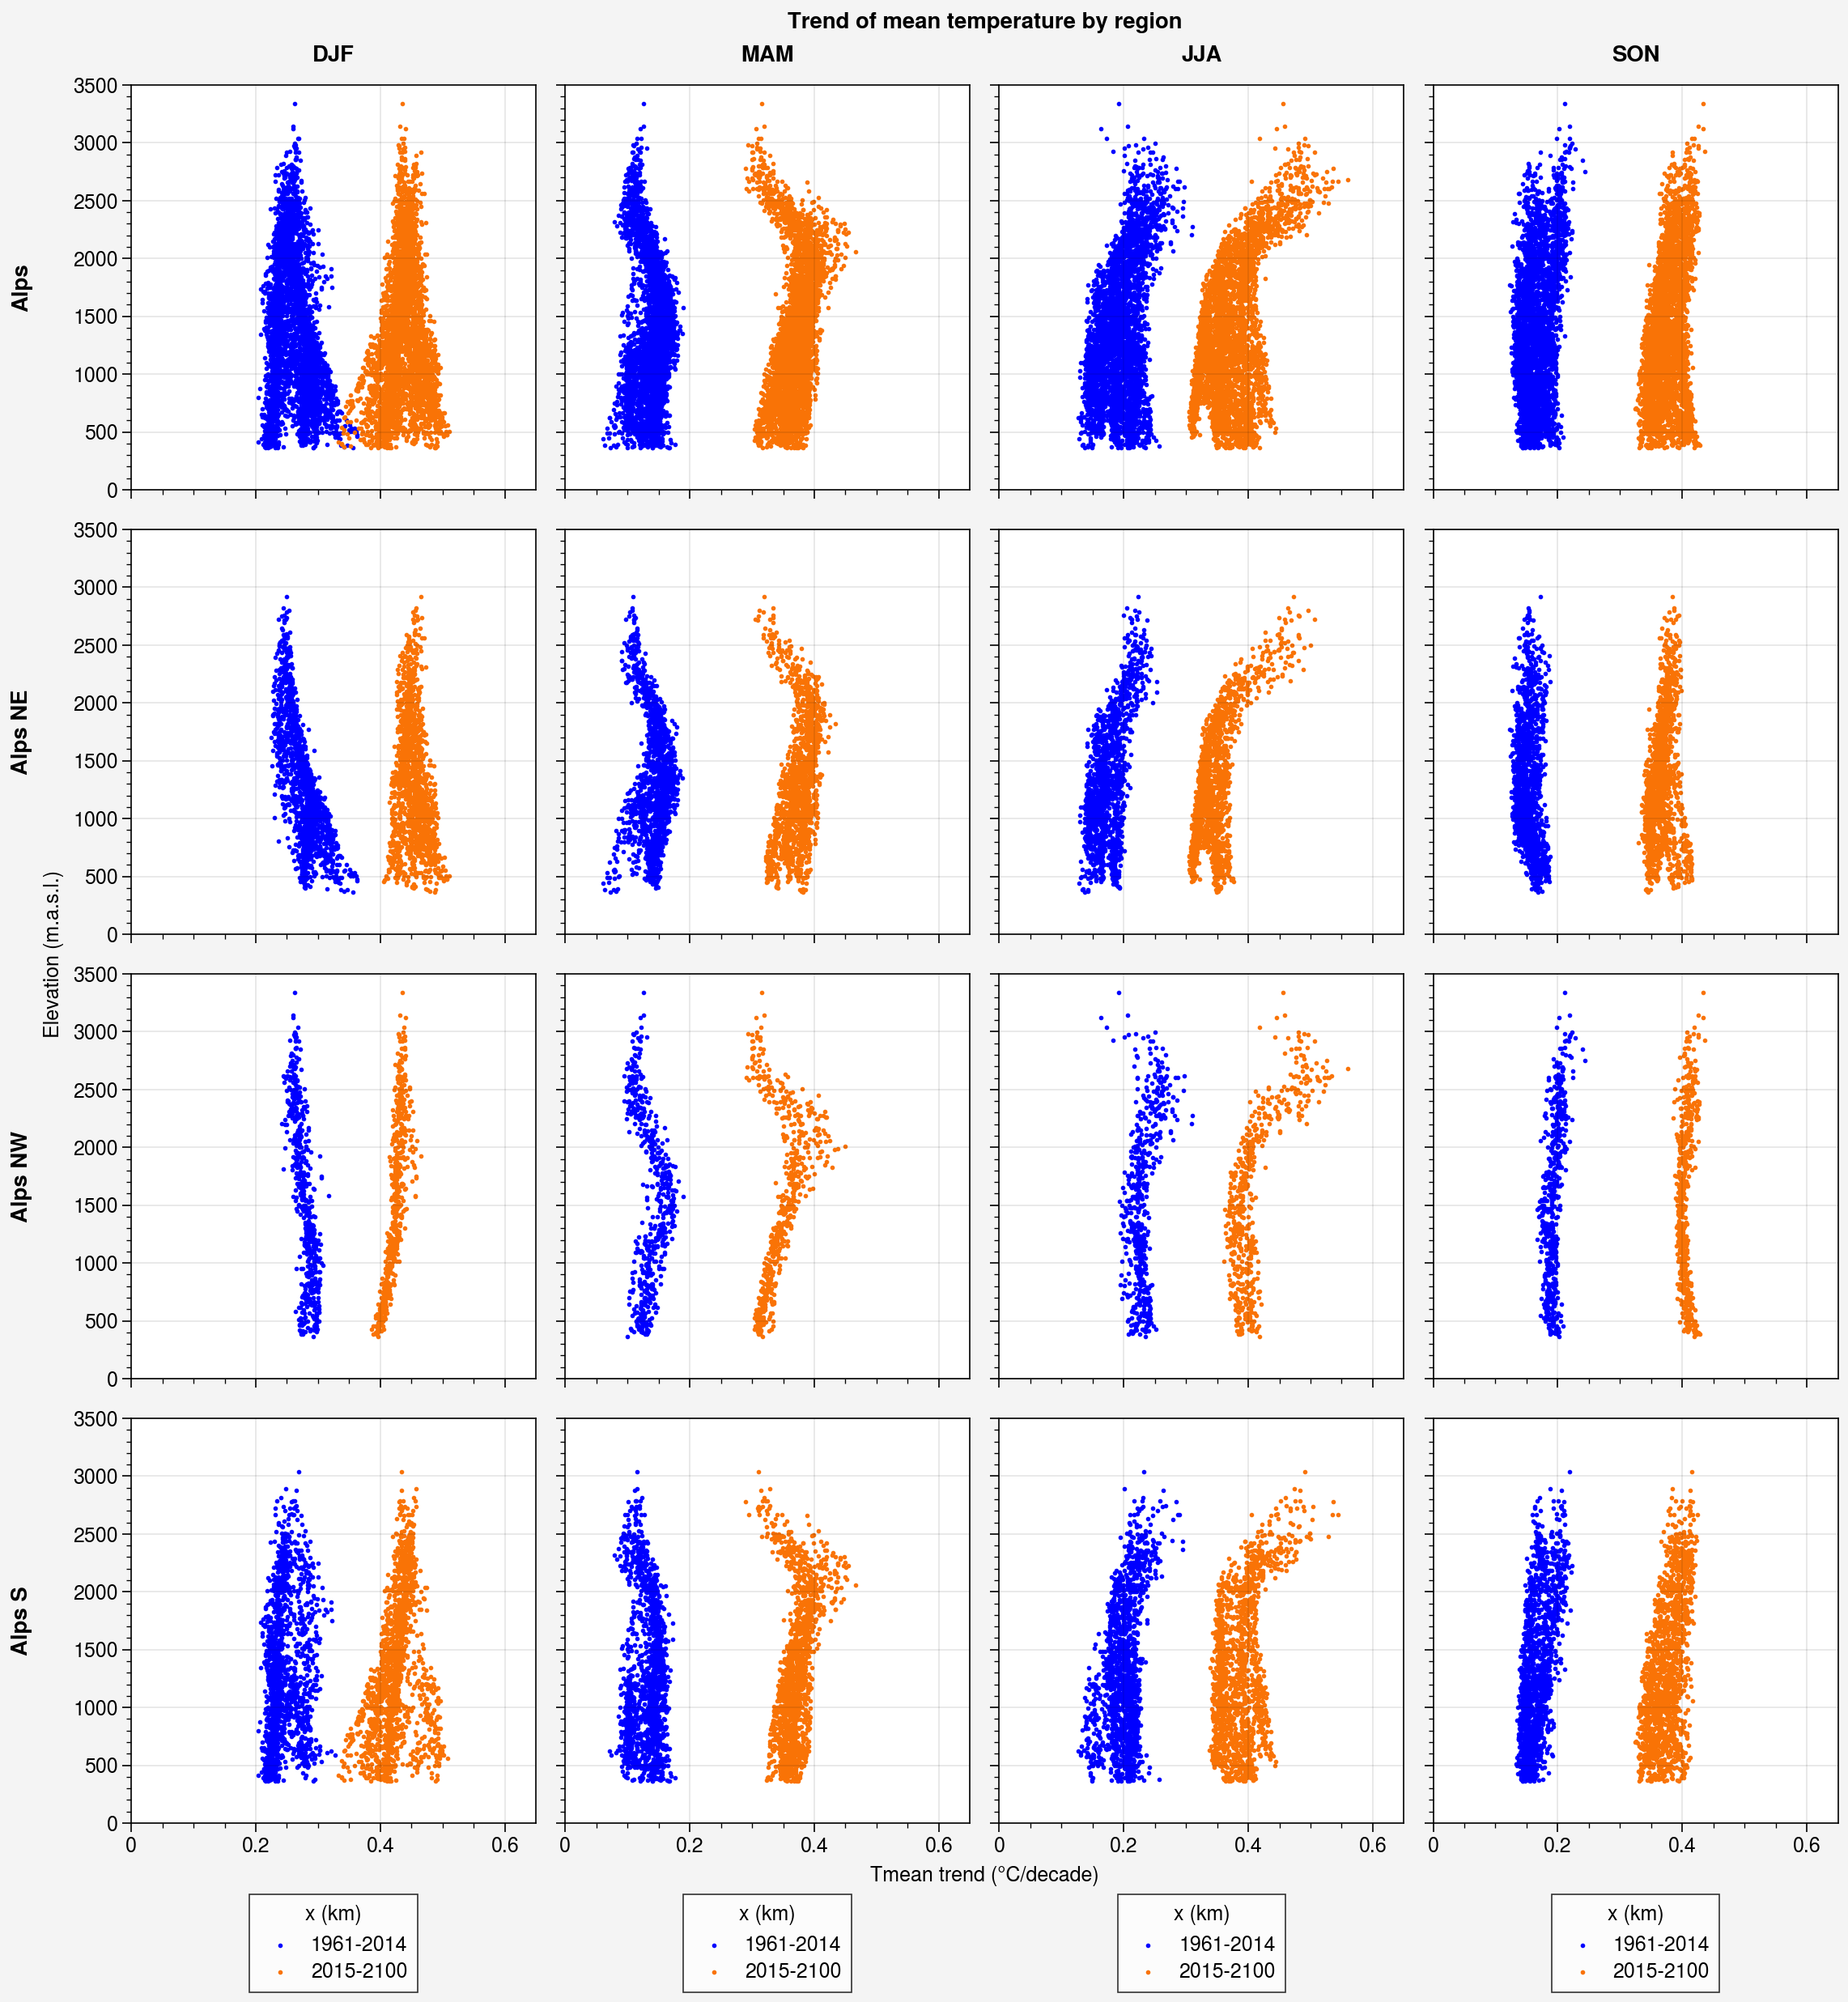

In [14]:
f, axs = pplt.subplots(ncols=4, nrows=4)
leg = ['1961-2014','2015-2100']

for i in range(4):
    slope_T_hist_0 = np.ma.masked_array(slope_T_hist[i], mask=np.invert(region_masks[0]))
    slope_T_hist_1 = np.ma.masked_array(slope_T_hist[i], mask=np.invert(region_masks[1]))
    slope_T_hist_2 = np.ma.masked_array(slope_T_hist[i], mask=np.invert(region_masks[2]))
    slope_T_hist_3 = np.ma.masked_array(slope_T_hist[i], mask=np.invert(region_masks[3]))
    slopes=[slope_T_hist_0,slope_T_hist_1,slope_T_hist_2,slope_T_hist_3]
    
    for j,slope in enumerate(slopes):
        ax = axs[i+4*j]
        blue_dot = ax.scatter(10*slope,ds.SH[jmin:jmax,imin:imax],s=2,c='b')
        
    
for i in range(4):
    slope_T_fut_0 = np.ma.masked_array(slope_T_fut[i], mask=np.invert(region_masks[0]))
    slope_T_fut_1 = np.ma.masked_array(slope_T_fut[i], mask=np.invert(region_masks[1]))
    slope_T_fut_2 = np.ma.masked_array(slope_T_fut[i], mask=np.invert(region_masks[2]))
    slope_T_fut_3 = np.ma.masked_array(slope_T_fut[i], mask=np.invert(region_masks[3]))
    slopes=[slope_T_fut_0,slope_T_fut_1,slope_T_fut_2,slope_T_fut_3]
    
    for j,slope in enumerate(slopes):
        ax = axs[i+4*j]
        orange_dot = ax.scatter(10*slope,ds.SH[jmin:jmax,imin:imax],s=2,c='orange')
        ax.set_xlim((0.,0.65))
        ax.set_ylim((0.,3500))
        if(j==3):
            ax.legend([blue_dot,orange_dot],leg,loc='bottom')

axs.format(suptitle='Trend of mean temperature by region',collabels=['DJF','MAM','JJA', 'SON'],
           rowlabels=names_regions,xlabel='Tmean trend (°C/decade)',ylabel='Elevation (m.a.s.l.)')

In [15]:
l = 50 # length of periods

n = 140-l # number of periods

origin_T_periods=np.full((n, 4, 91, 139),np.nan)
slope_T_periods=np.full((n, 4, 91, 139),np.nan)


for year in np.arange(0,n):
    print(year,end=' ')
    endyear = year+l
    wp_meanseason_meanT_period = wp_meanseason_meanT_spfit_2k[year:endyear,:,:,:]
    for i in range(wp_meanseason_meanT_spfit_2k.shape[3]):
        # print(str(lon)+'/'+str(les_season_maxT.shape[3]),end=' ')
        for j in range(wp_meanseason_meanT_spfit_2k.shape[2]):
            for season in range(4):
                slope_T_periods[year][season][j][i] = (wp_meanseason_meanT_period[-1,season,j,i] - wp_meanseason_meanT_period[0,season,j,
                                                       i])/wp_meanseason_meanT_period.shape[0]
                
                #linregress_T = linregress(np.arange(wp_meanseason_meanT_period.shape[0]), wp_meanseason_meanT_period[:,season,j,i])
                #origin_T_periods[year][season][j][i] = linregress_T.intercept
                #slope_T_periods[year][season][j][i] = linregress_T.slope
                #pvalue_T_periods[year][season][j][i] = linregress_T.pvalue


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 

In [16]:
l = 30 # length of periods

n = 140-l # number of periods

origin_T_periods30=np.full((n, 4, 91, 139),np.nan)
slope_T_periods30=np.full((n, 4, 91, 139),np.nan)


for year in np.arange(0,n):
    print(year,end=' ')
    endyear = year+l
    wp_meanseason_meanT_period = wp_meanseason_meanT_spfit_2k[year:endyear,:,:,:]
    for i in range(wp_meanseason_meanT_spfit_2k.shape[3]):
        # print(str(lon)+'/'+str(les_season_maxT.shape[3]),end=' ')
        for j in range(wp_meanseason_meanT_spfit_2k.shape[2]):
            for season in range(4):
                slope_T_periods30[year][season][j][i] = (wp_meanseason_meanT_period[-1,season,j,i] - wp_meanseason_meanT_period[0,season,j,
                                                       i])/wp_meanseason_meanT_period.shape[0]

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 

In [17]:
def spline_fit_4reg(period_slopes,N_seas,knot_numbers,yfitminpercent=10,yfitmaxpercent=5):

    Nperiods = period_slopes.shape[0]
    
    height_new = np.linspace(0, 1, knot_numbers+2)[1:-1]
    height_max = np.full((4,Nperiods),np.nan) # 4 regions, N periods
    value_max = np.full((4,Nperiods),np.nan) # 4 regions, N periods
    
    for region in range(4):
        height = np.ma.masked_array(ds.SH[jmin:jmax,imin:imax], mask=np.invert(region_masks[region]))
        vec_height = height[height.mask == False]
        for i in range(Nperiods):
            slope_seas = 10*np.ma.masked_array(period_slopes[i,N_seas], mask=np.invert(region_masks[region]))
            vec_slope_seas = slope_seas[slope_seas.mask == False]
            
            vec_height_srt = [y for (y,x) in sorted(zip(vec_height,vec_slope_seas), key=lambda pair: pair[0])]
            vec_slope_seas_srt = [x for (y,x) in sorted(zip(vec_height,vec_slope_seas), key=lambda pair: pair[0])]
            
            q_knots = np.quantile(vec_height_srt, height_new)
            
            t,c,k = interpolate.splrep(vec_height_srt, vec_slope_seas_srt, t=q_knots, s=1)
            yfit = interpolate.BSpline(t,c,k)(vec_height_srt)
            
            yfitmin = int(yfitminpercent/100*len(yfit))
            yfitmax = int(yfitmaxpercent/100*len(yfit))
            vec_height_srt_redux = vec_height_srt[yfitmin:-yfitmax]
            height_max[region,i] = vec_height_srt_redux[np.argmax(yfit[yfitmin:-yfitmax])]
            value_max[region,i] = np.max(yfit[yfitmin:-yfitmax])

        print(yfitmin, " ",yfitmax,end=" ")
        print(yfit.shape)
    
    return height_max, value_max

In [18]:
def spline_fit_4reg2(period_slopes,N_seas,knot_numbers,yfitminpercent=10,yfitmaxpercent=5):

    Nperiods = period_slopes.shape[0]
    
    height_new = np.linspace(0, 1, knot_numbers+2)[1:-1]
    height_max = np.full((4,Nperiods),np.nan) # 4 regions, N periods
    value_max = np.full((4,Nperiods),np.nan) # 4 regions, N periods
    
    for region in range(4):
        height = np.ma.masked_array(ds.SH[jmin:jmax,imin:imax], mask=np.invert(region_masks[region]))
        vec_height = height[height.mask == False]
        for i in range(Nperiods):
            slope_seas = 10*np.ma.masked_array(period_slopes[i,N_seas], mask=np.invert(region_masks[region]))
            vec_slope_seas = slope_seas[slope_seas.mask == False]
            
            vec_height_srt = [y for (y,x) in sorted(zip(vec_height,vec_slope_seas), key=lambda pair: pair[0])]
            vec_slope_seas_srt = [x for (y,x) in sorted(zip(vec_height,vec_slope_seas), key=lambda pair: pair[0])]
            
            q_knots = np.quantile(vec_height_srt, height_new)
            
            t,c,k = interpolate.splrep(vec_height_srt, vec_slope_seas_srt, t=q_knots, s=1)
            yfit = interpolate.BSpline(t,c,k)(vec_height_srt)
            
            yfitmin = int(yfitminpercent/100*len(yfit))
            yfitmax = int(yfitmaxpercent/100*len(yfit))
            vec_height_srt_redux = vec_height_srt[yfitmin:-yfitmax]
            height_max[region,i] = vec_height_srt_redux[np.argmax(yfit[yfitmin:-yfitmax])]
            value_max[region,i] = np.max(vec_slope_seas_srt[yfitmin:-yfitmax])

        print(yfitmin, " ",yfitmax,end=" ")
        print(yfit.shape)
    
    return height_max, value_max

In [19]:
height_max_k9_MAM, value_max_k9_MAM = spline_fit_4reg(slope_T_periods,1,9,yfitminpercent=5,yfitmaxpercent=1)

height_max_k5_MAM, value_max_k5_MAM = spline_fit_4reg(slope_T_periods,1,5,yfitminpercent=5,yfitmaxpercent=1)

height_max_k3_MAM, value_max_k3_MAM = spline_fit_4reg(slope_T_periods,1,3,yfitminpercent=5,yfitmaxpercent=1)

177   35 (3556,)
73   14 (1471,)
27   5 (546,)
76   15 (1539,)
177   35 (3556,)
73   14 (1471,)
27   5 (546,)
76   15 (1539,)
177   35 (3556,)
73   14 (1471,)
27   5 (546,)
76   15 (1539,)


In [33]:
height_max_k9_MAM_2, value_max_k9_MAM_2 = spline_fit_4reg2(slope_T_periods,1,9,yfitminpercent=5,yfitmaxpercent=1)

height_max_k5_MAM_2, value_max_k5_MAM_2 = spline_fit_4reg2(slope_T_periods,1,5,yfitminpercent=5,yfitmaxpercent=1)

height_max_k3_MAM_2, value_max_k3_MAM_2 = spline_fit_4reg2(slope_T_periods,1,3,yfitminpercent=5,yfitmaxpercent=1)

177   35 (3556,)
73   14 (1471,)
27   5 (546,)
76   15 (1539,)
177   35 (3556,)
73   14 (1471,)
27   5 (546,)
76   15 (1539,)
177   35 (3556,)
73   14 (1471,)
27   5 (546,)
76   15 (1539,)


In [19]:
height_max_k9_MAM_30, value_max_k9_MAM_30 = spline_fit_4reg(slope_T_periods30,1,9,yfitminpercent=5,yfitmaxpercent=1)

height_max_k5_MAM_30, value_max_k5_MAM_30 = spline_fit_4reg(slope_T_periods30,1,5,yfitminpercent=5,yfitmaxpercent=1)

height_max_k3_MAM_30, value_max_k3_MAM_30 = spline_fit_4reg(slope_T_periods30,1,3,yfitminpercent=5,yfitmaxpercent=1)

177   35 (3556,)
73   14 (1471,)
27   5 (546,)
76   15 (1539,)
177   35 (3556,)
73   14 (1471,)
27   5 (546,)
76   15 (1539,)
177   35 (3556,)
73   14 (1471,)
27   5 (546,)
76   15 (1539,)


Text(0.5, 1.0, '3 knots')

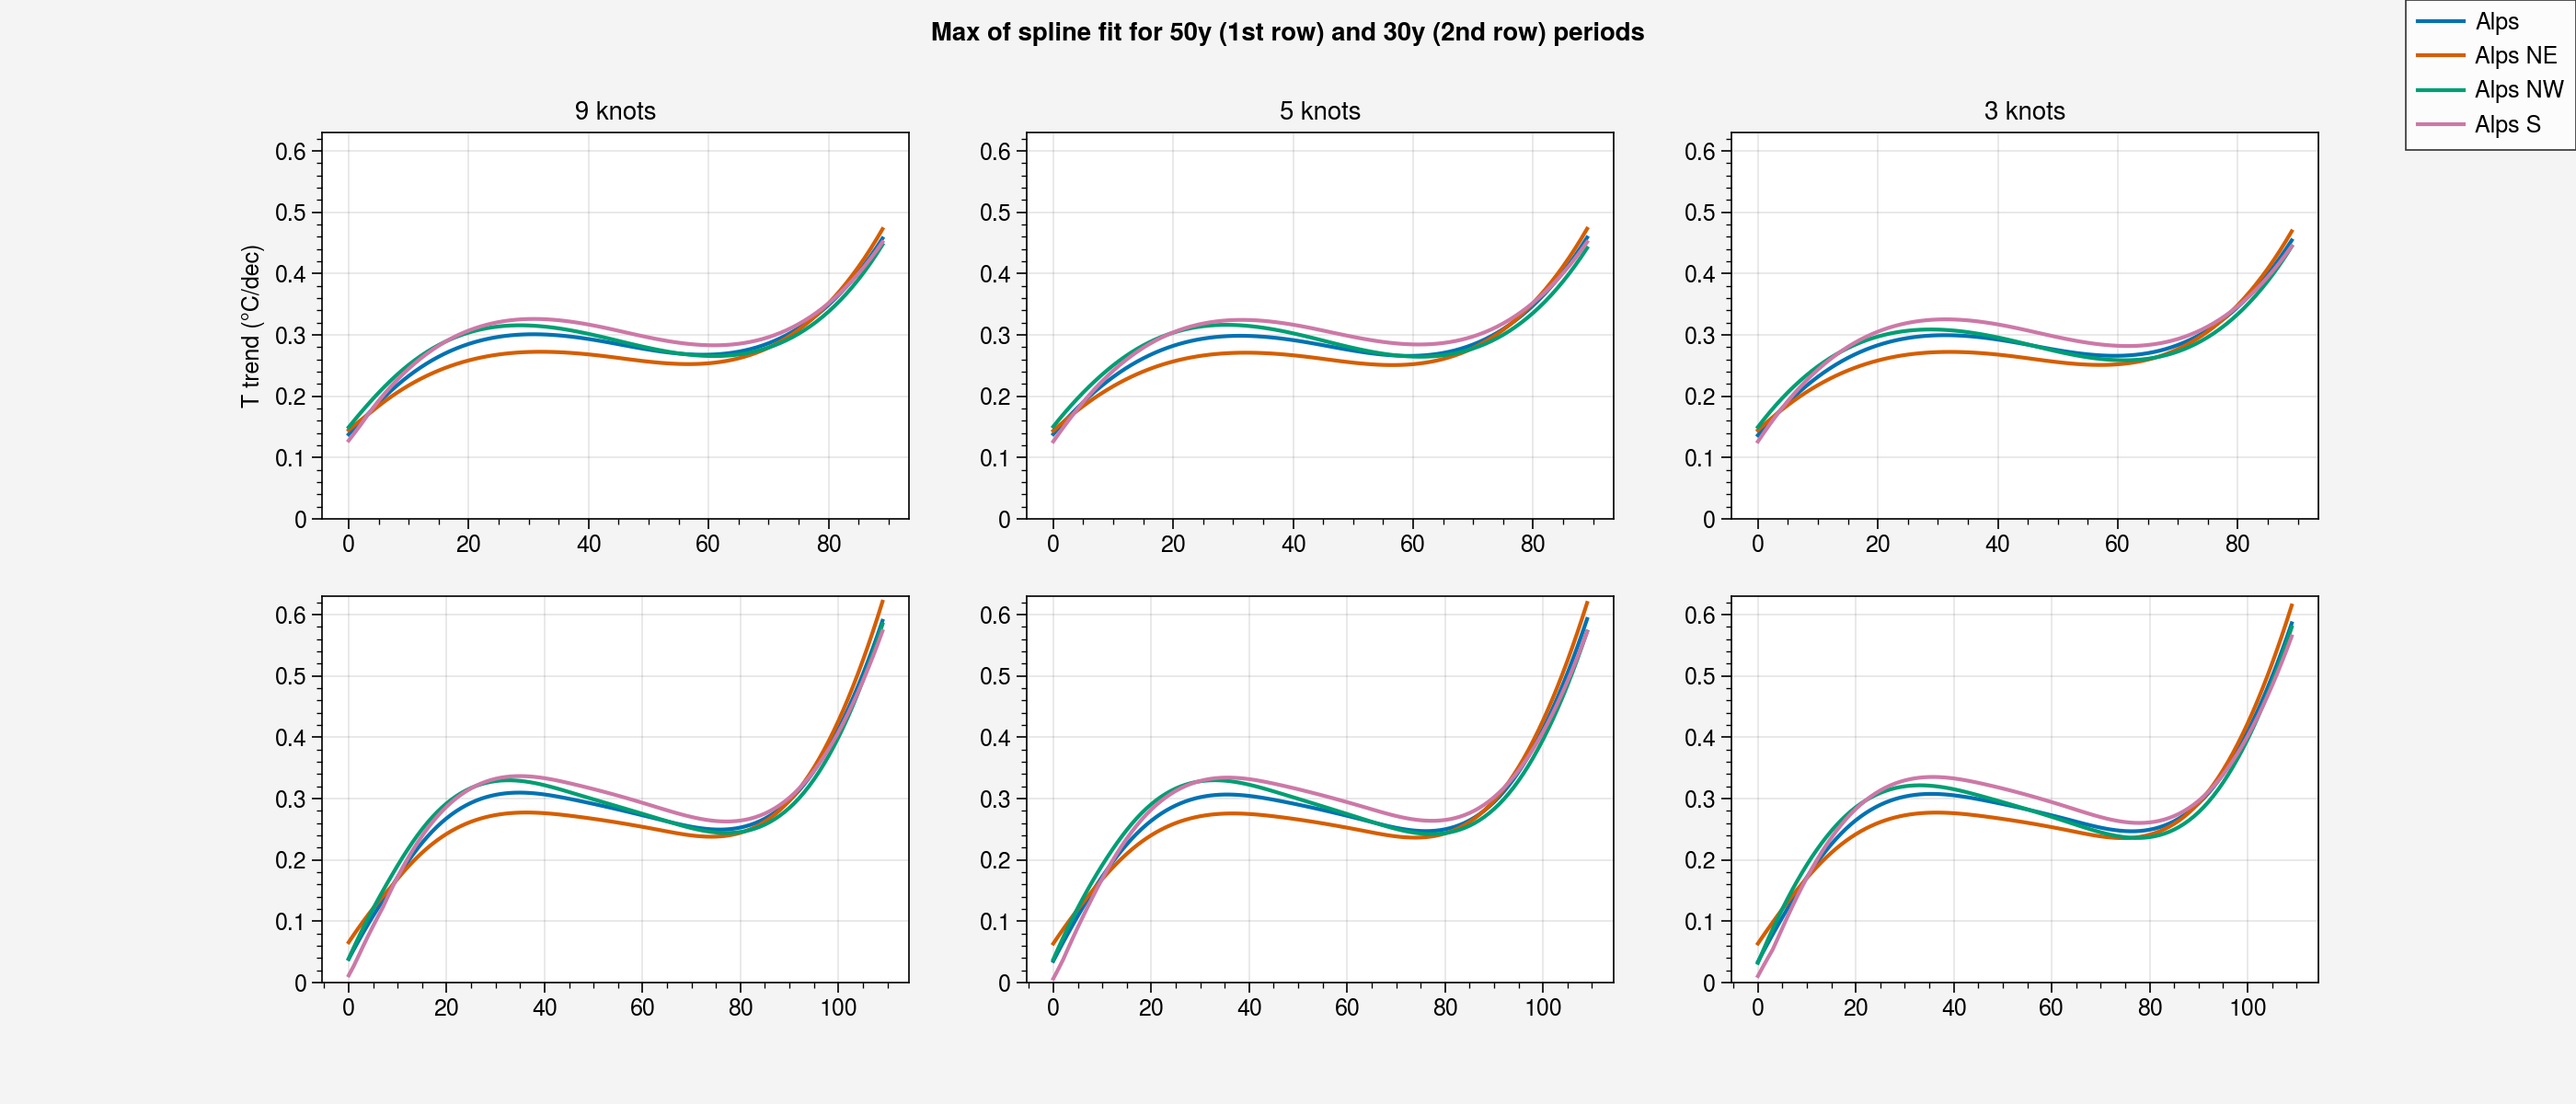

In [20]:
ig, ax = plt.subplots(ncols=3, nrows=2, figsize=(14, 6))

for i in range(4):
    ax[0,0].plot(value_max_k9_MAM[i],label=names_regions[i])
    ax[0,0].set_ylim([0,0.63])
    ax[0,1].plot(value_max_k5_MAM[i])
    ax[0,1].set_ylim([0,0.63])
    ax[0,2].plot(value_max_k3_MAM[i])
    ax[0,2].set_ylim([0,0.63])

    ax[1,0].plot(value_max_k9_MAM_30[i])
    ax[1,0].set_ylim([0,0.63])
    ax[1,1].plot(value_max_k5_MAM_30[i])
    ax[1,1].set_ylim([0,0.63])
    ax[1,2].plot(value_max_k3_MAM_30[i])
    ax[1,2].set_ylim([0,0.63])

ig.legend()
ig.suptitle('Max of spline fit for 50y (1st row) and 30y (2nd row) periods')
ax[0,0].set_title('9 knots')
ax[0,0].set_ylabel('T trend (°C/dec)')
ax[0,1].set_title('5 knots')
ax[0,2].set_title('3 knots')

Text(0.5, 1.0, '3 knots')

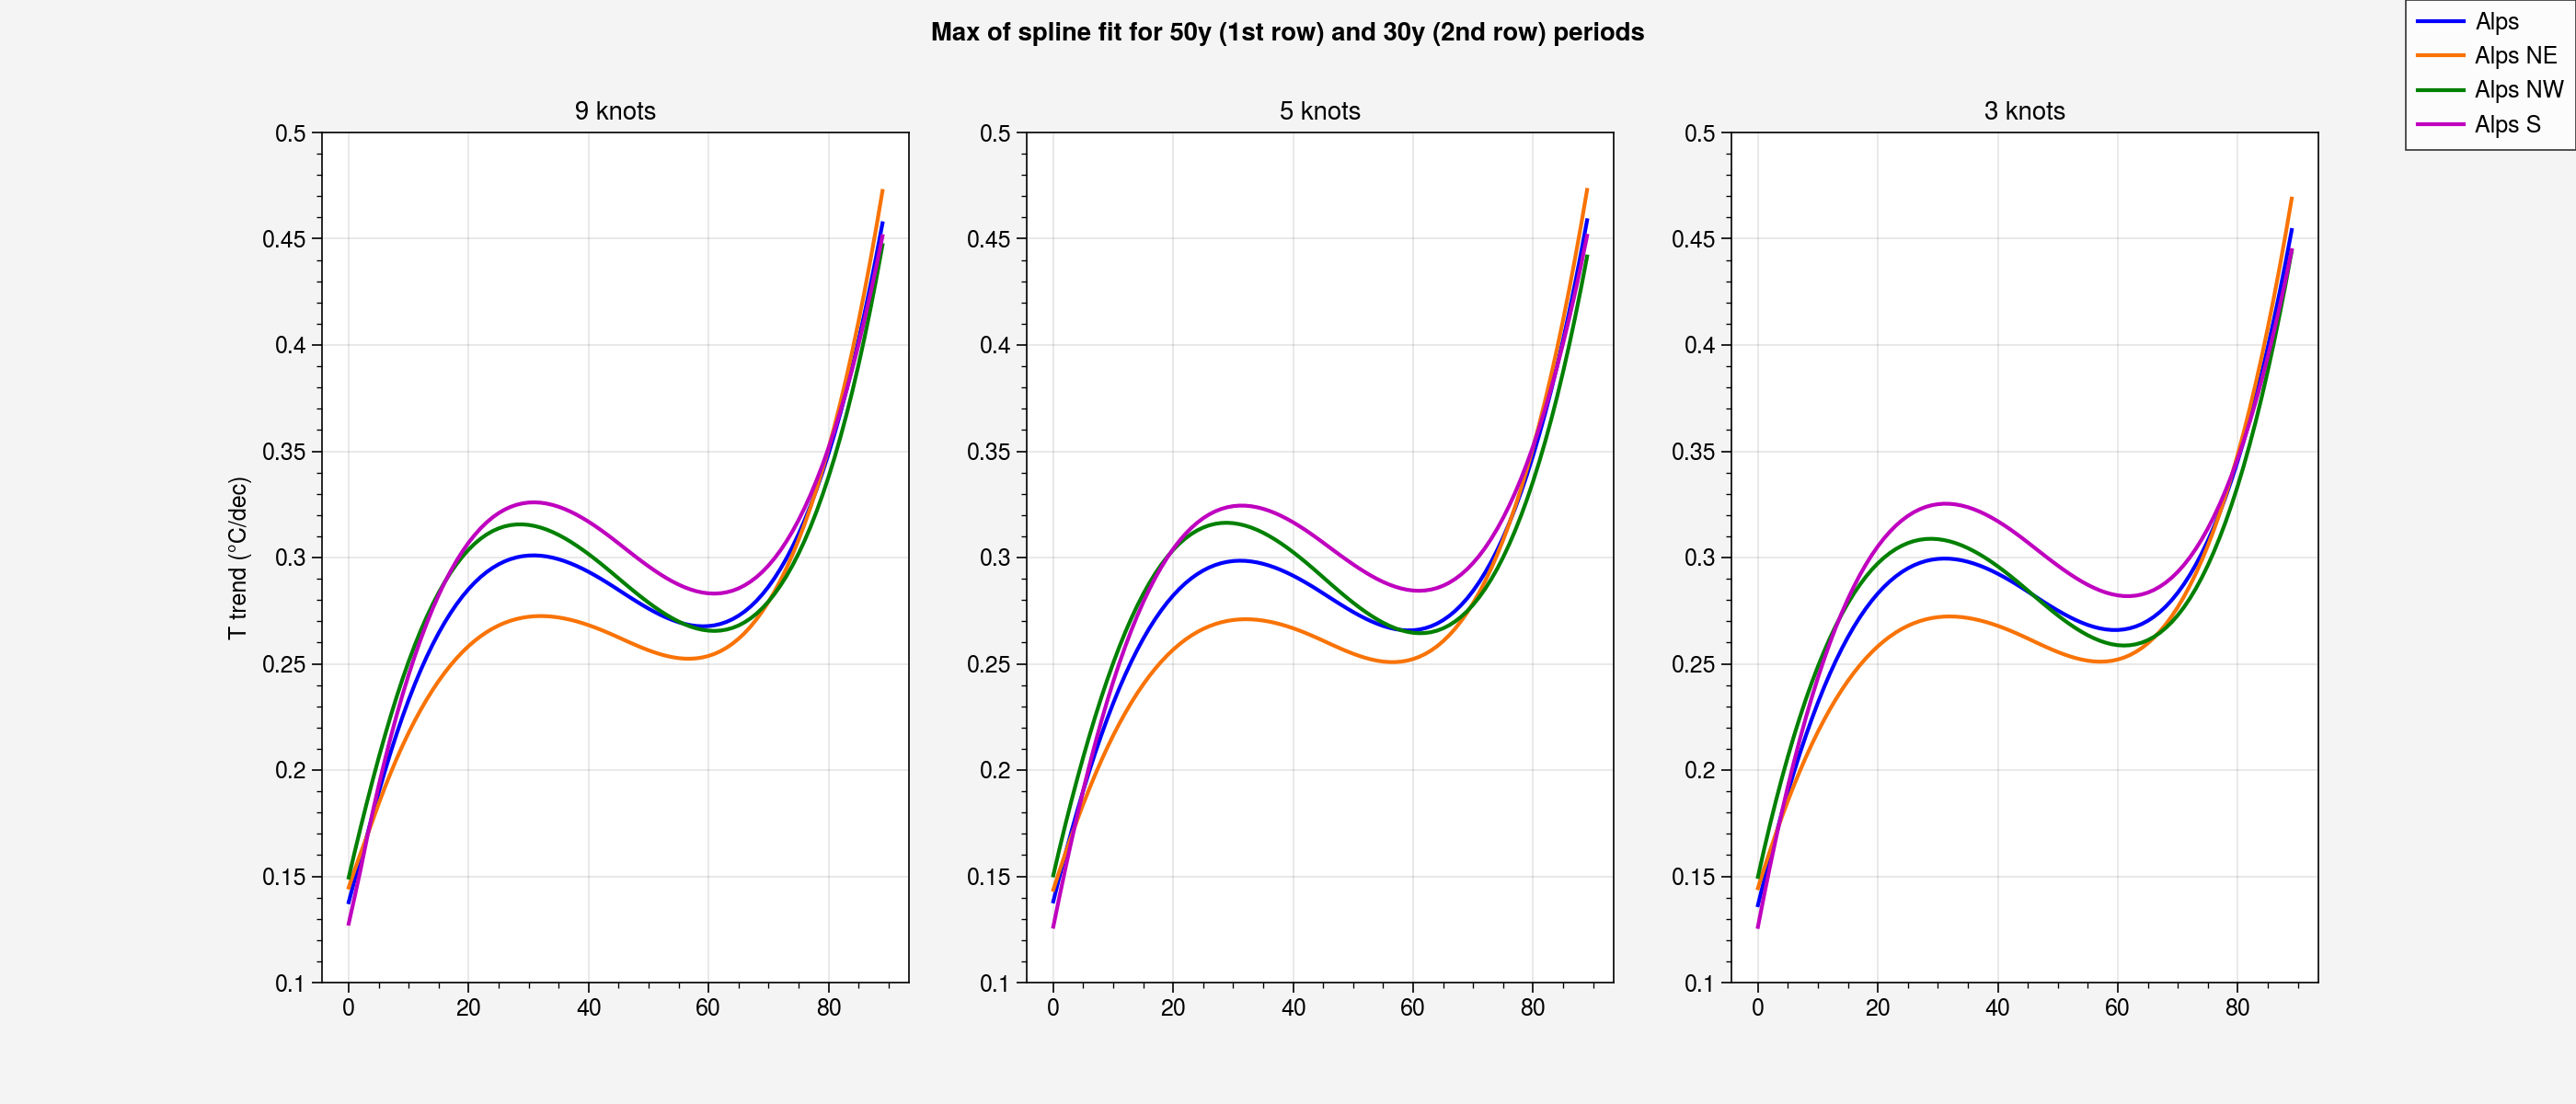

In [42]:
ig, ax = plt.subplots(ncols=3, figsize=(14, 6))

colorss = ['b','orange','g','m']

for i in range(4):
    ax[0].plot(value_max_k9_MAM[i],label=names_regions[i],c=colorss[i])
    ax[0].set_ylim([0.1,0.5])
    ax[1].plot(value_max_k5_MAM[i],c=colorss[i])
    ax[1].set_ylim([0.1,0.5])
    ax[2].plot(value_max_k3_MAM[i],c=colorss[i])
    ax[2].set_ylim([0.1,0.5])

    #ax[0].plot(value_max_k9_MAM_2[i],linestyle='--',c=colorss[i])
    #ax[1].plot(value_max_k5_MAM_2[i],linestyle='--',c=colorss[i])
    #ax[2].plot(value_max_k3_MAM_2[i],linestyle='--',c=colorss[i])

ig.legend()
ig.suptitle('Max of spline fit for 50y (1st row) and 30y (2nd row) periods')
ax[0].set_title('9 knots')
ax[0].set_ylabel('T trend (°C/dec)')
ax[1].set_title('5 knots')
ax[2].set_title('3 knots')

Text(0.5, 1.0, '3 knots')

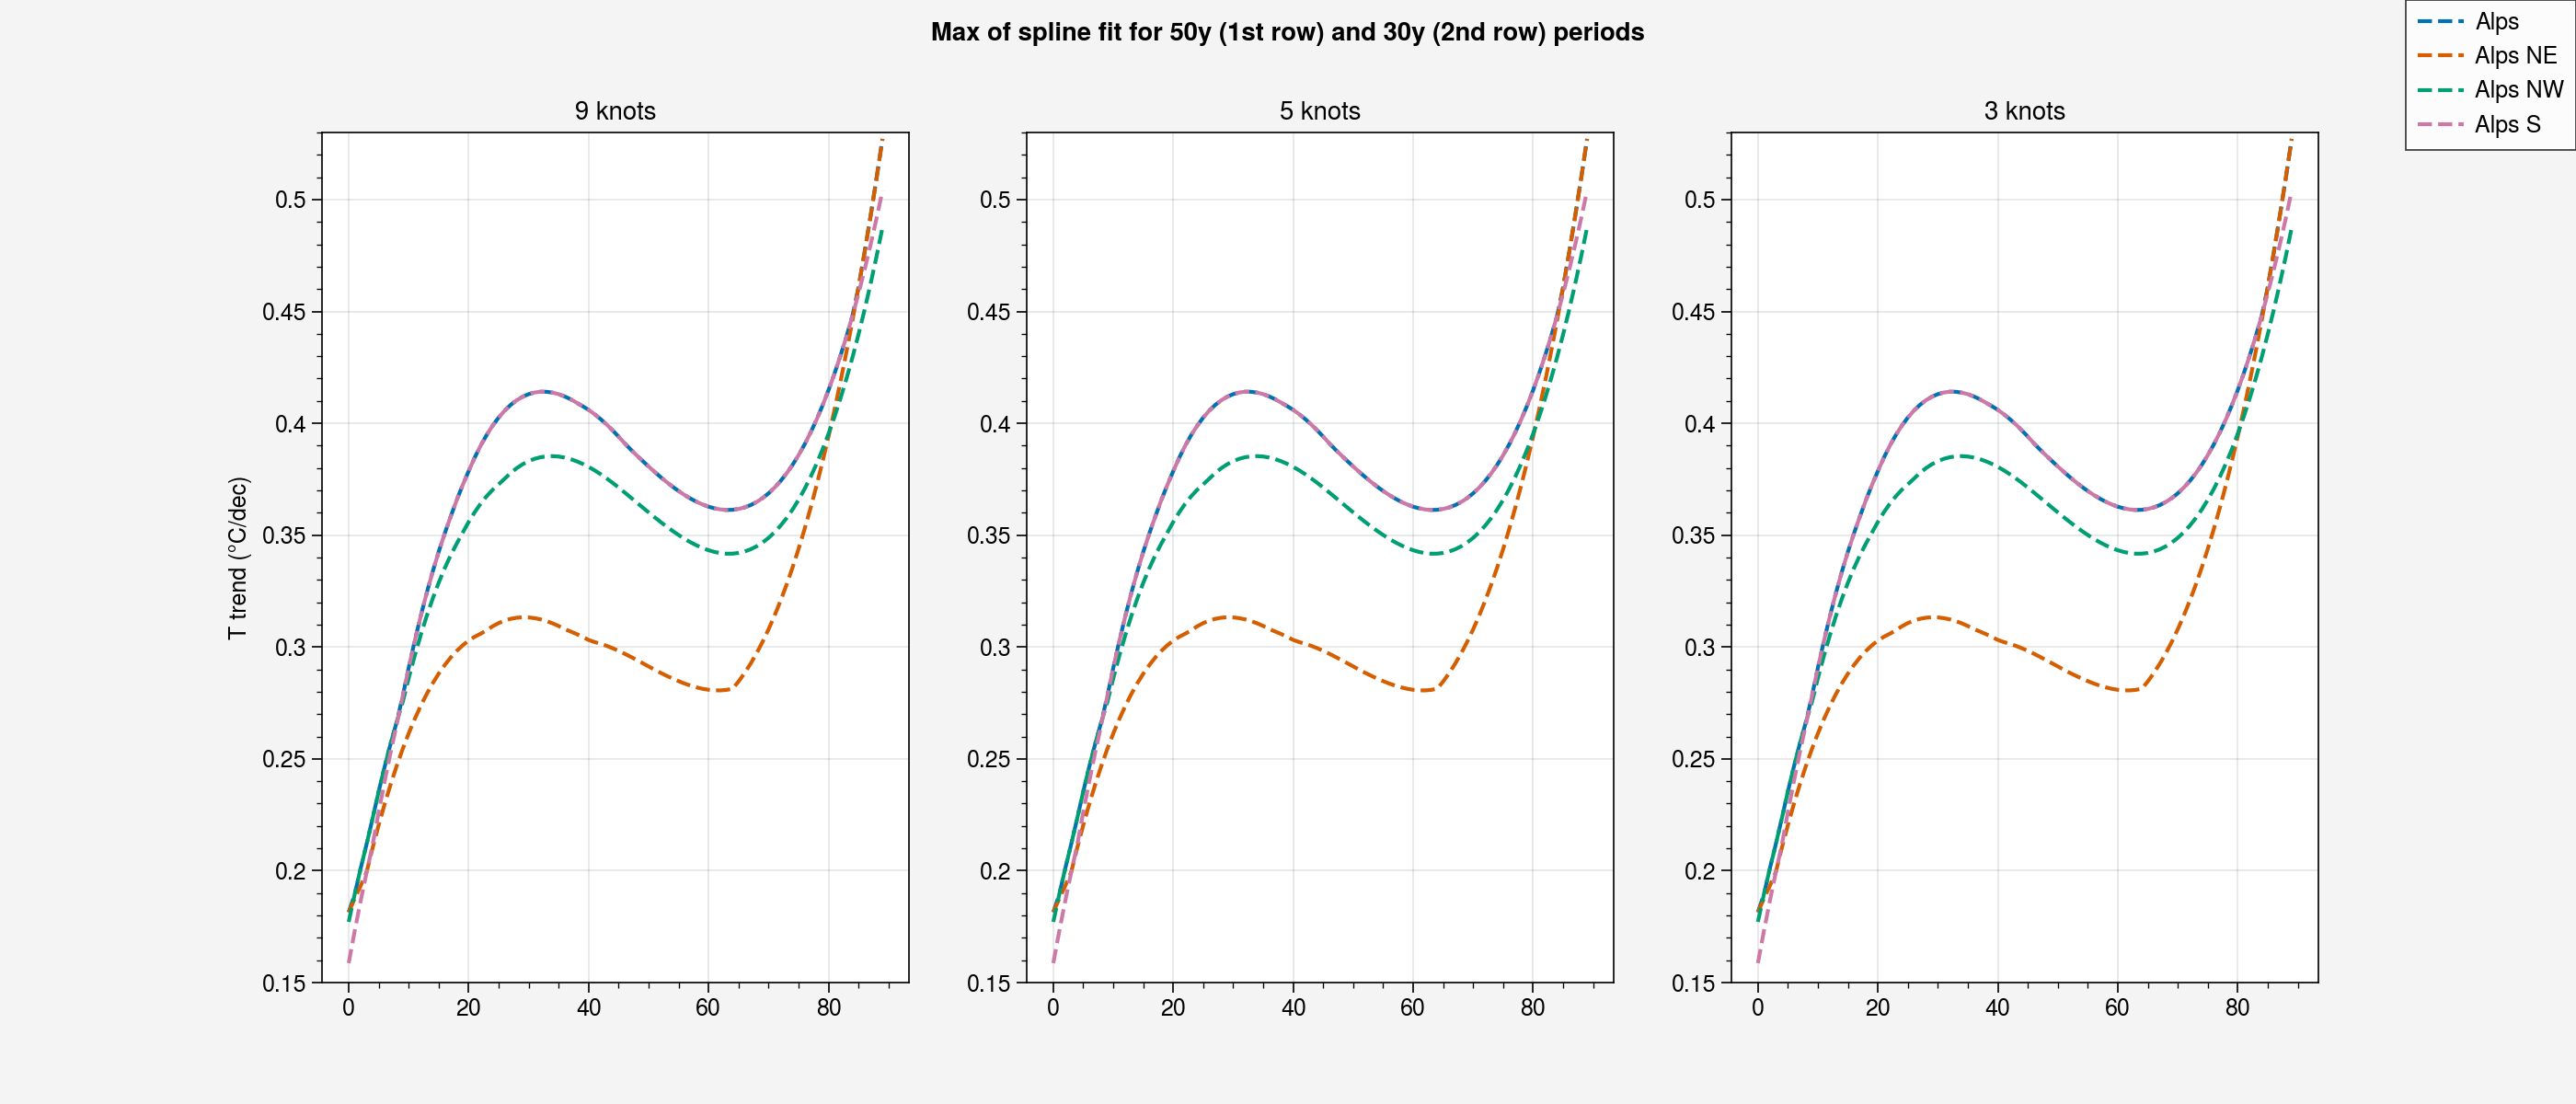

In [41]:
ig, ax = plt.subplots(ncols=3, figsize=(14, 6))

for i in range(4):
    ax[0].plot(value_max_k9_MAM_2[i],label=names_regions[i],linestyle='--')
    ax[0].set_ylim([0.15,0.53])
    ax[1].plot(value_max_k5_MAM_2[i],linestyle='--')
    ax[1].set_ylim([0.15,0.53])
    ax[2].plot(value_max_k3_MAM_2[i],linestyle='--')
    ax[2].set_ylim([0.15,0.53])

ig.legend()
ig.suptitle('Max of spline fit for 50y (1st row) and 30y (2nd row) periods')
ax[0].set_title('9 knots')
ax[0].set_ylabel('T trend (°C/dec)')
ax[1].set_title('5 knots')
ax[2].set_title('3 knots')

In [26]:
value_max_k5_MAM[2]

array([0.15043773, 0.16257379, 0.17418661, 0.18530374, 0.19595065,
       0.20614809, 0.21590688, 0.22522686, 0.23409817, 0.24250892,
       0.25044608, 0.2579005 , 0.26486794, 0.27134825, 0.27734404,
       0.28286253, 0.28791174, 0.29250031, 0.29664007, 0.30034075,
       0.303621  , 0.30648812, 0.30895769, 0.31104471, 0.31275906,
       0.31412871, 0.31515455, 0.31585554, 0.31624904, 0.31634532,
       0.31615945, 0.31570726, 0.31501876, 0.3141071 , 0.31297568,
       0.31164034, 0.31011695, 0.30842338, 0.30657794, 0.30459254,
       0.30248614, 0.30027216, 0.29796716, 0.29558705, 0.29314683,
       0.29066868, 0.28818709, 0.28573112, 0.283324  , 0.28098245,
       0.27872372, 0.27656506, 0.27452372, 0.27262624, 0.27088404,
       0.26931063, 0.26792329, 0.26673934, 0.2657761 , 0.26505087,
       0.26458096, 0.26438368, 0.26447635, 0.26487627, 0.26560674,
       0.26668093, 0.26811459, 0.26992507, 0.27213005, 0.27474774,
       0.27779565, 0.28128998, 0.28525321, 0.28969942, 0.29464

Text(0.5, 1.0, '3 knots')

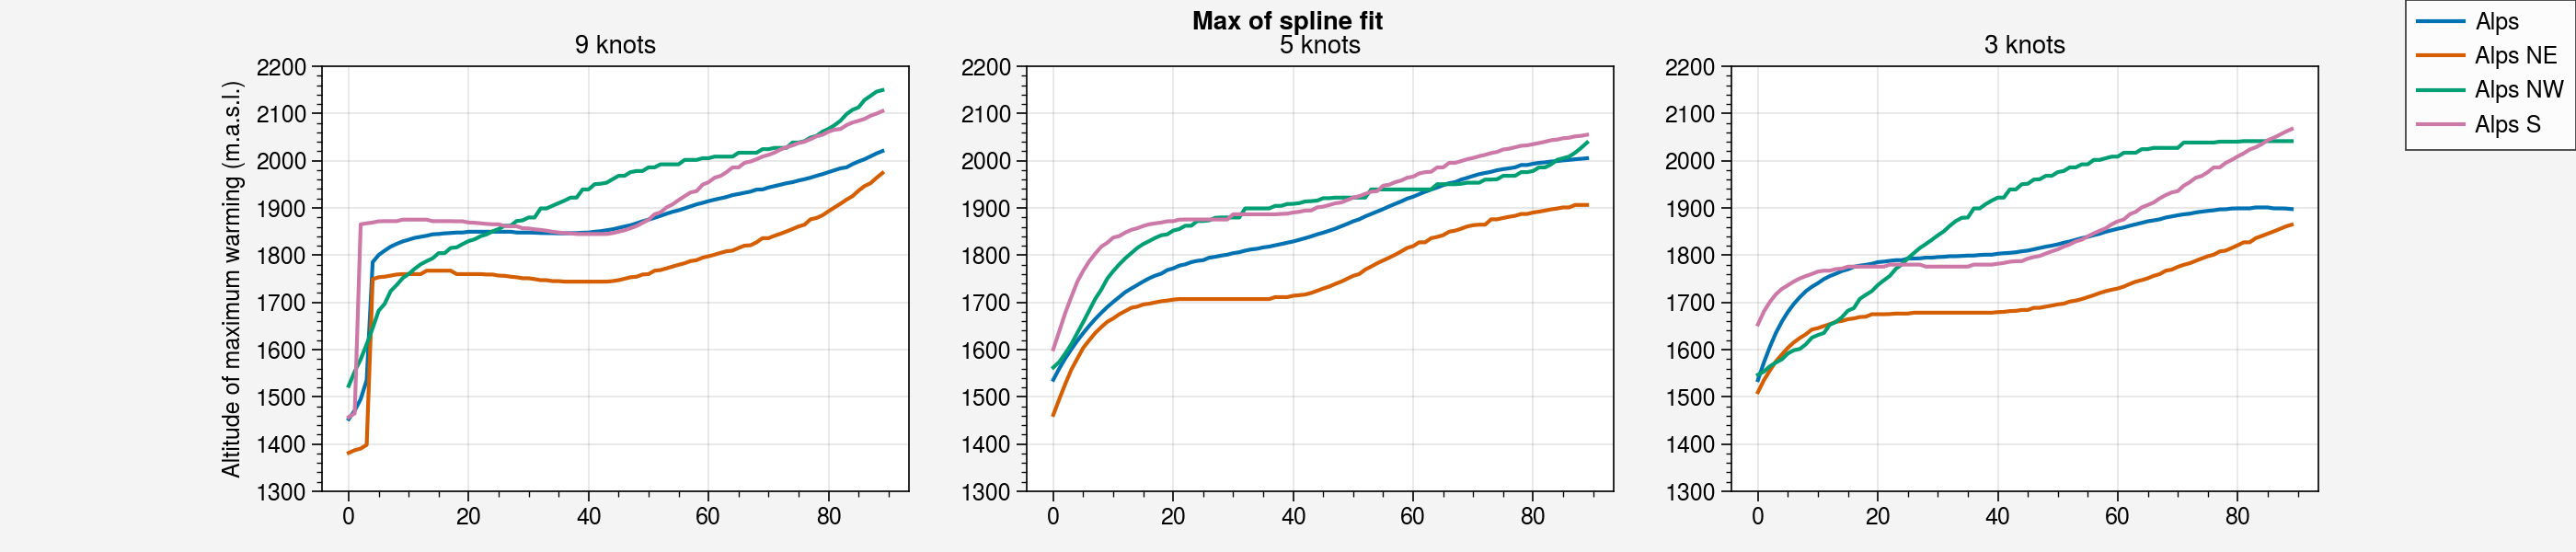

In [52]:
ig, ax = plt.subplots(ncols=3, figsize=(14, 3))

for i in range(4):
    ax[0].plot(height_max_k9_MAM[i],label=names_regions[i])
    ax[0].set_ylim([1300,2200])
    ax[1].plot(height_max_k5_MAM[i])
    ax[1].set_ylim([1300,2200])
    ax[2].plot(height_max_k3_MAM[i])
    ax[2].set_ylim([1300,2200])

ig.legend()
ig.suptitle('Max of spline fit')
ax[0].set_title('9 knots')
ax[0].set_ylabel('Altitude of maximum warming (m.a.s.l.)')
ax[1].set_title('5 knots')
ax[2].set_title('3 knots')

Text(0.5, 1.0, '3 knots')

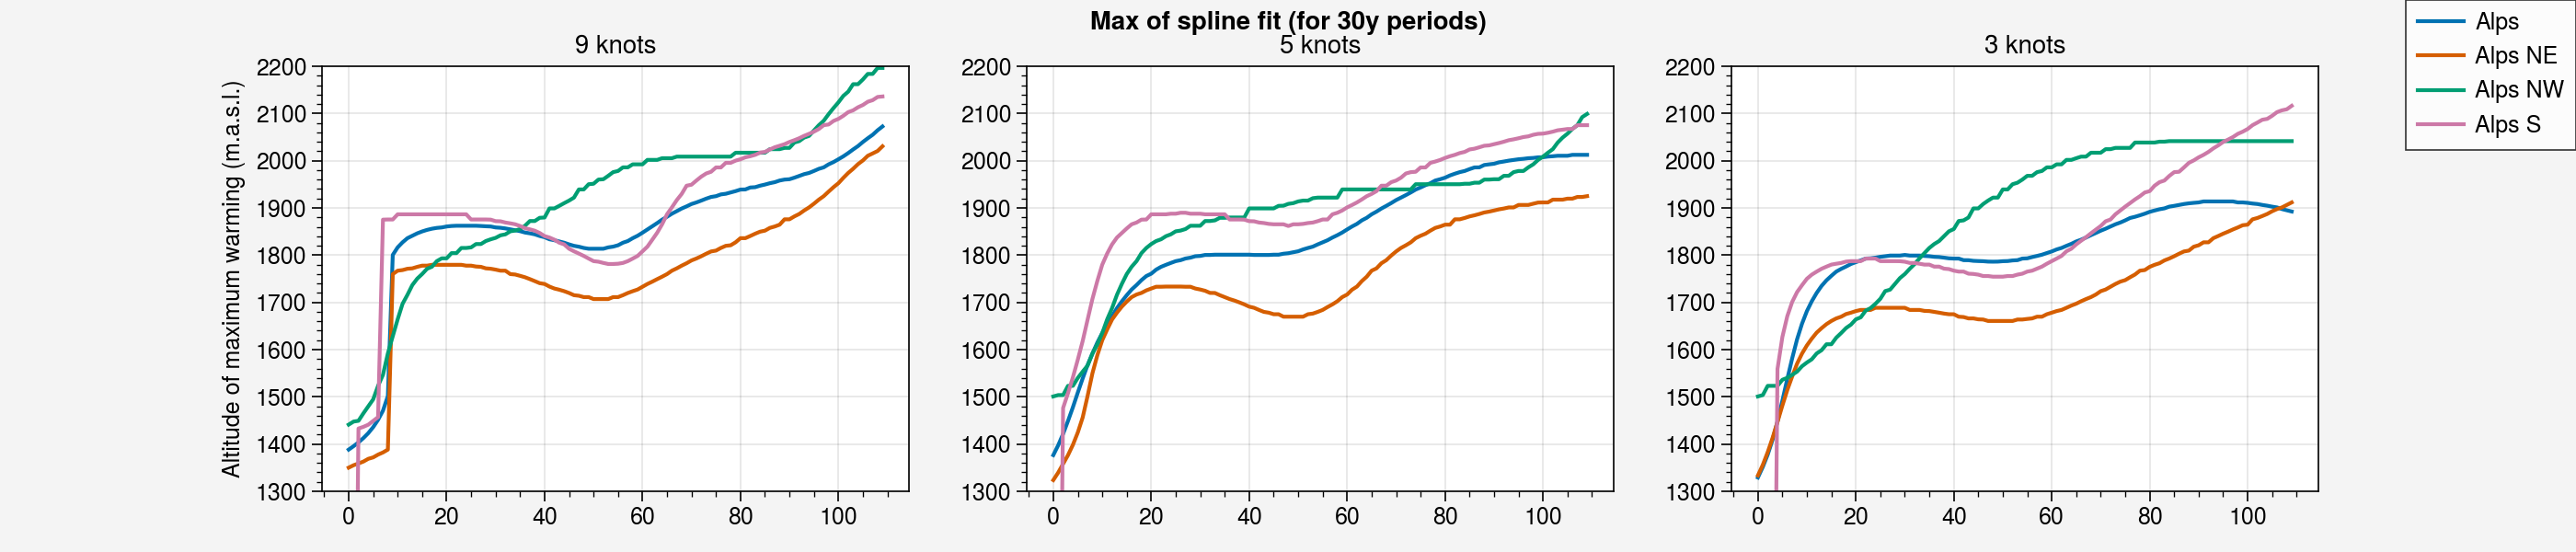

In [54]:
ig, ax = plt.subplots(ncols=3, figsize=(14, 3))

for i in range(4):
    ax[0].plot(height_max_k9_MAM_30[i],label=names_regions[i])
    ax[0].set_ylim([1300,2200])
    ax[1].plot(height_max_k5_MAM_30[i])
    ax[1].set_ylim([1300,2200])
    ax[2].plot(height_max_k3_MAM_30[i])
    ax[2].set_ylim([1300,2200])

ig.legend()
ig.suptitle('Max of spline fit (for 30y periods)')
ax[0].set_title('9 knots')
ax[0].set_ylabel('Altitude of maximum warming (m.a.s.l.)')
ax[1].set_title('5 knots')
ax[2].set_title('3 knots')

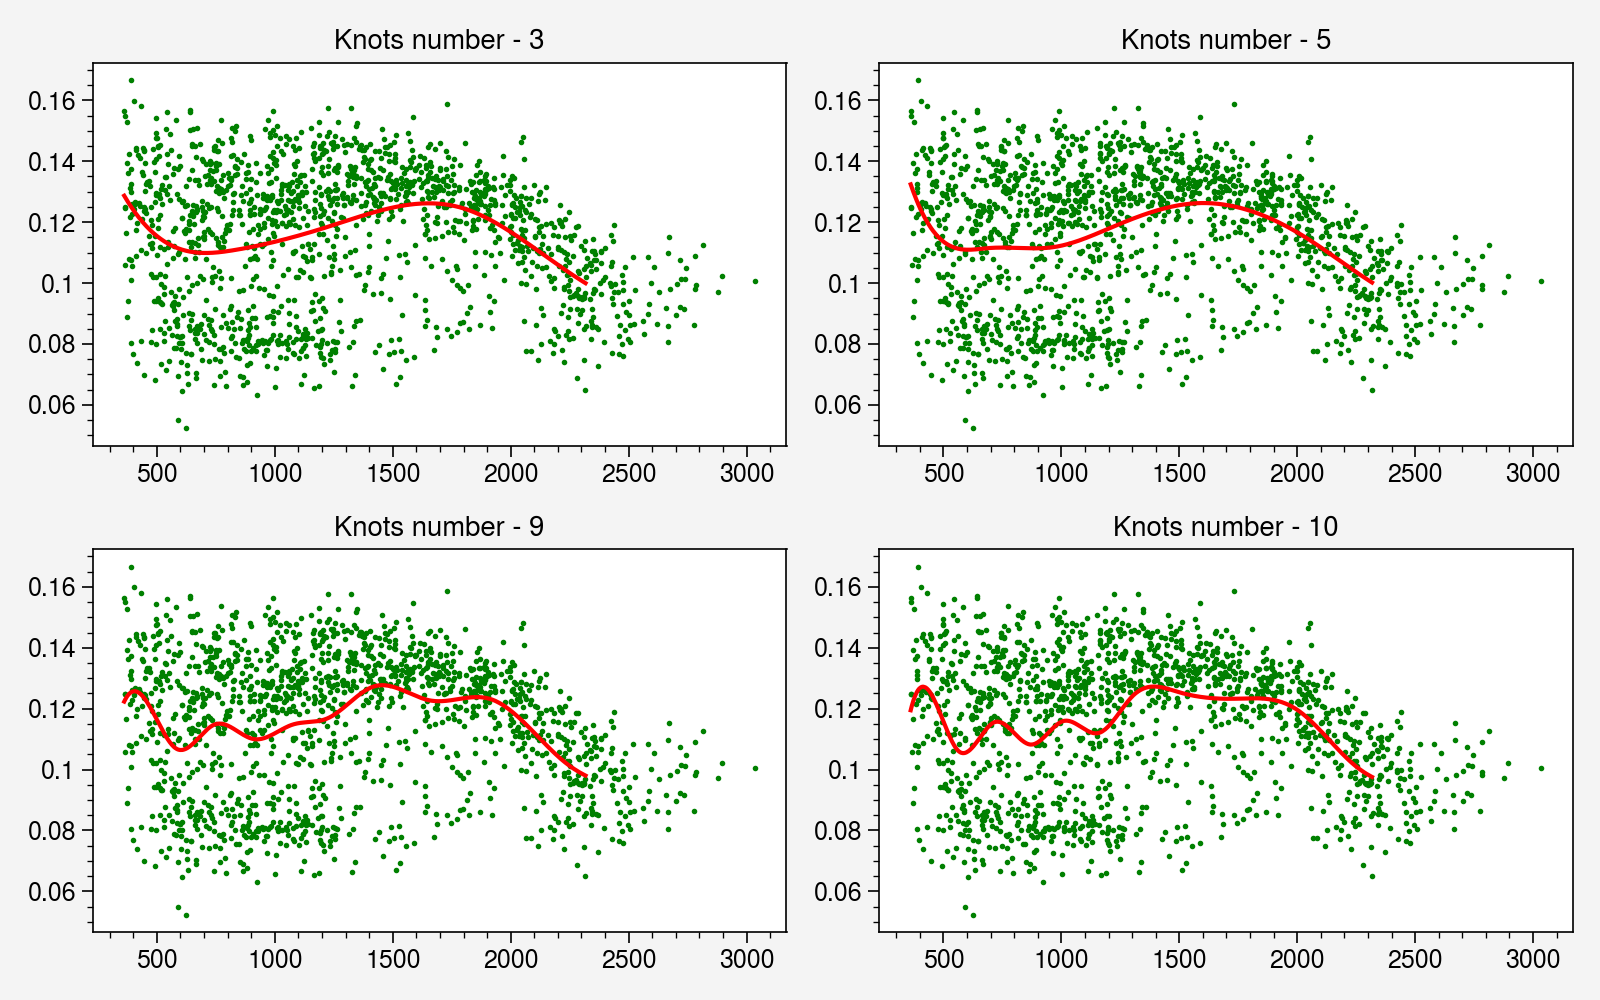

In [20]:
i=0

height = np.ma.masked_array(ds.SH[jmin:jmax,imin:imax], mask=np.invert(region_masks[3]))
vec_height = height[height.mask == False]

slope_T_MAM = 10*np.ma.masked_array(slope_T_periods[i,1], mask=np.invert(region_masks[3]))
vec_slope_T_MAM = slope_T_MAM[slope_T_MAM.mask == False]
        
vec_height_srt = [y for (y,x) in sorted(zip(vec_height,vec_slope_T_MAM), key=lambda pair: pair[0])]
vec_slope_T_MAM_srt = [x for (y,x) in sorted(zip(vec_height,vec_slope_T_MAM), key=lambda pair: pair[0])]


knots = [3, 5, 9, 10]
j=0

ig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 5))

for row in range(2):
    for col in range(2):
        ax[row][col].plot(vec_height_srt, vec_slope_T_MAM_srt, '.',c="g", markersize=2)
        yfit = spline(knots[j],vec_height_srt, vec_slope_T_MAM_srt)
        ax[row][col].plot(vec_height_srt[:-100], yfit[:-100], 'r')
        ax[row][col].set_title("Knots number - "+str(knots[j]))
        ax[row][col].grid()
        j=j+1
        
plt.tight_layout()        
plt.show()

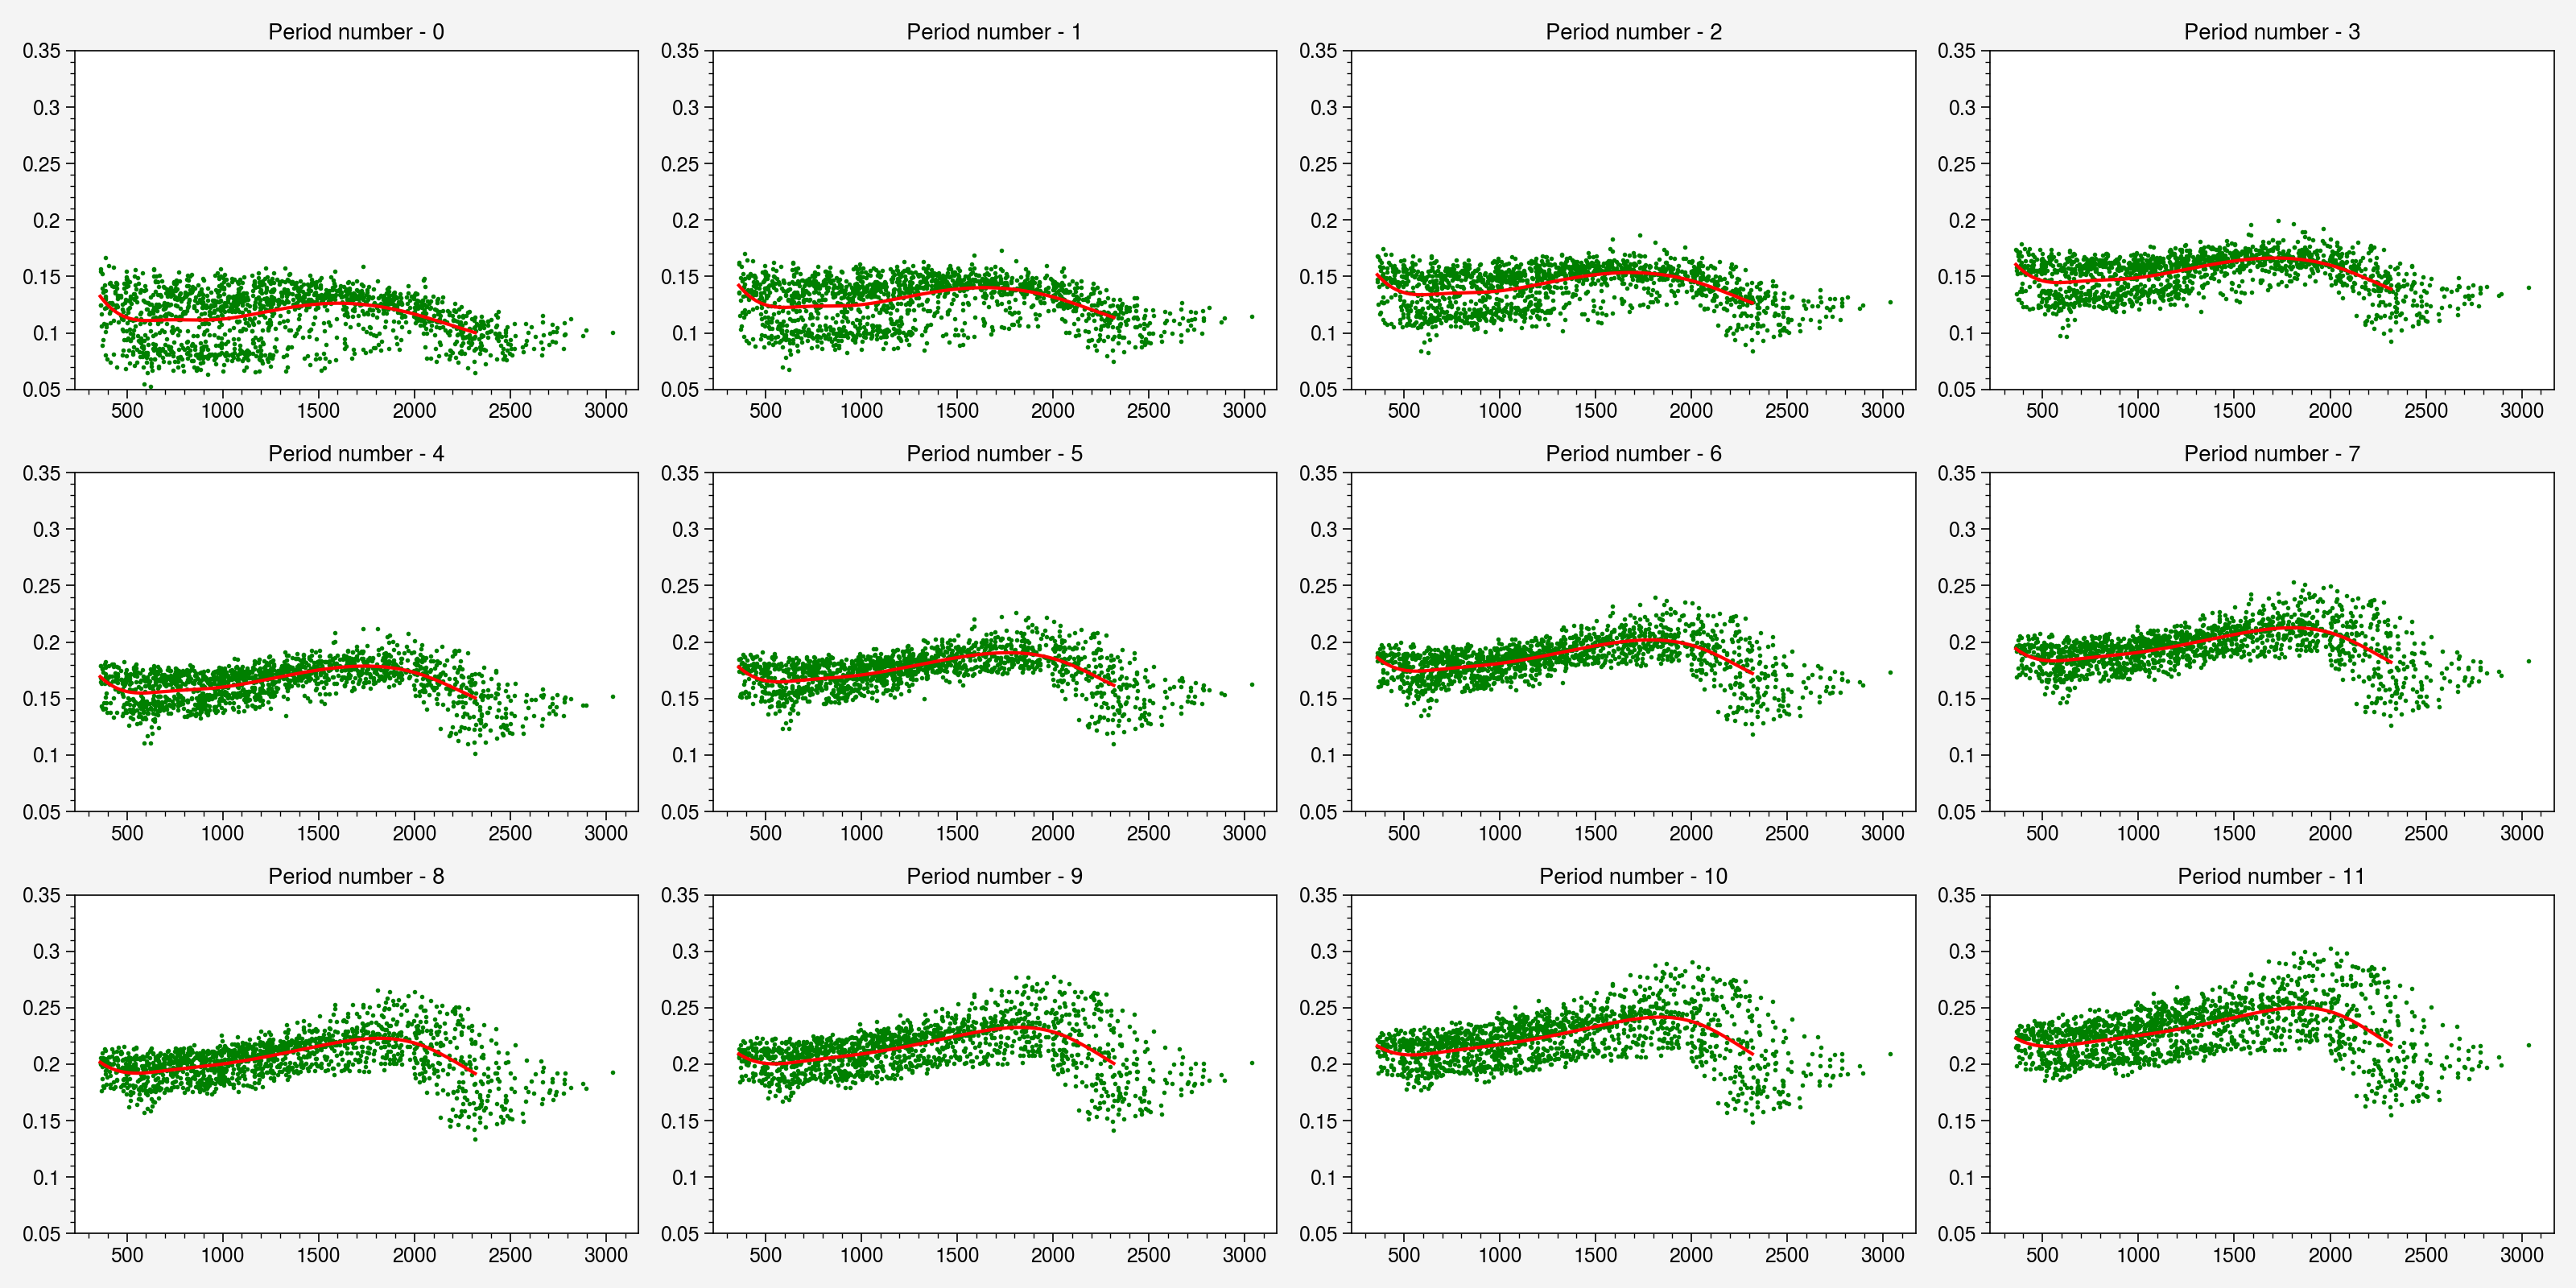

In [28]:
height = np.ma.masked_array(ds.SH[jmin:jmax,imin:imax], mask=np.invert(region_masks[3]))
vec_height = height[height.mask == False]

knots=5

j=0

ig, ax = plt.subplots(nrows=3, ncols=4, figsize=(16, 8))

for row in range(3):
    for col in range(4):
        slope_T_MAM = 10*np.ma.masked_array(slope_T_periods[j,1], mask=np.invert(region_masks[3]))
        vec_slope_T_MAM = slope_T_MAM[slope_T_MAM.mask == False]
        
        vec_height_srt = [y for (y,x) in sorted(zip(vec_height,vec_slope_T_MAM), key=lambda pair: pair[0])]
        vec_slope_T_MAM_srt = [x for (y,x) in sorted(zip(vec_height,vec_slope_T_MAM), key=lambda pair: pair[0])]
        
        ax[row][col].plot(vec_height_srt, vec_slope_T_MAM_srt, '.',c="g", markersize=2)
        yfit = spline(knots,vec_height_srt, vec_slope_T_MAM_srt)
        ax[row][col].plot(vec_height_srt[:-100], yfit[:-100], 'r')
        ax[row][col].set_title("Period number - "+str(j))
        ax[row][col].grid()
        ax[row][col].set_ylim(0.05,0.35)
        j=j+1
        
plt.tight_layout()        
plt.show()

In [21]:
# No exclusion, 9, 5 and 3 knots

height_max_k9_MAM_norestrict, value_max_k9_MAM_norestrict = spline_fit_4reg(slope_T_periods,1,9,yfitminpercent=0,yfitmaxpercent=0.2)
height_max_k5_MAM_norestrict, value_max_k5_MAM_norestrict = spline_fit_4reg(slope_T_periods,1,5,yfitminpercent=0,yfitmaxpercent=0.2)
height_max_k3_MAM_norestrict, value_max_k3_MAM_norestrict = spline_fit_4reg(slope_T_periods,1,3,yfitminpercent=0,yfitmaxpercent=0.2)

0   7 (3556,)
0   2 (1471,)
0   1 (546,)
0   3 (1539,)
0   7 (3556,)
0   2 (1471,)
0   1 (546,)
0   3 (1539,)
0   7 (3556,)
0   2 (1471,)
0   1 (546,)
0   3 (1539,)


Text(0.5, 1.0, '3 knots')

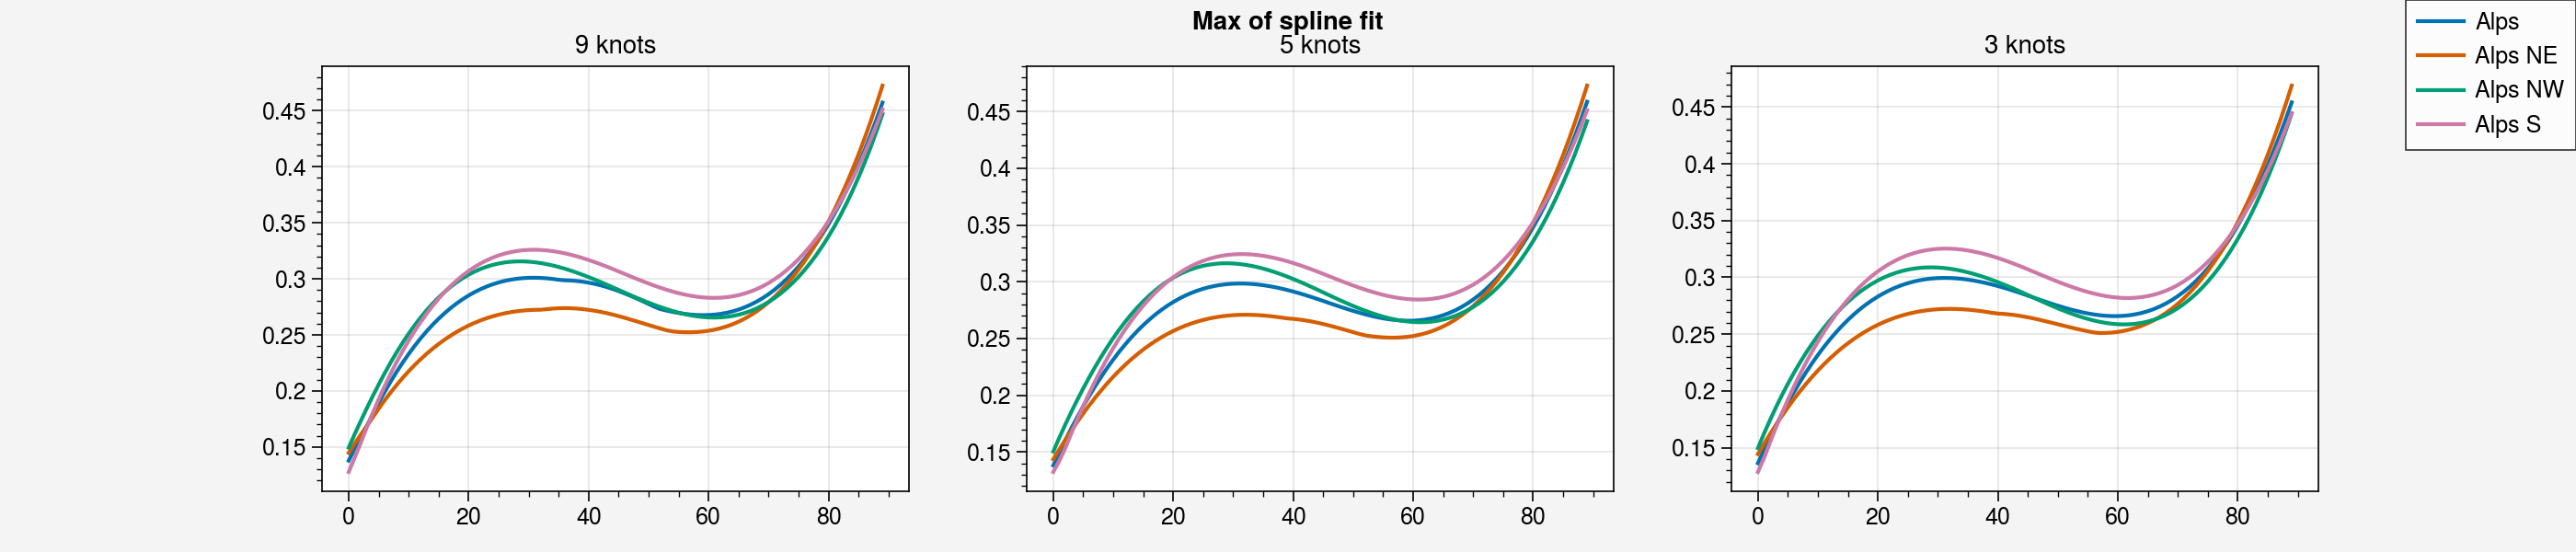

In [22]:
ig, ax = plt.subplots(ncols=3, figsize=(14, 3))

for i in range(4):
    ax[0].plot(value_max_k9_MAM_norestrict[i],label=names_regions[i])
    #ax[0].set_ylim([1300,2200])
    ax[1].plot(value_max_k5_MAM_norestrict[i])
    #ax[1].set_ylim([1300,2200])
    ax[2].plot(value_max_k3_MAM_norestrict[i])
    #ax[2].set_ylim([1300,2200])

ig.legend()
ig.suptitle('Max of spline fit')
ax[0].set_title('9 knots')
ax[1].set_title('5 knots')
ax[2].set_title('3 knots')

Text(0.5, 1.0, '3 knots')

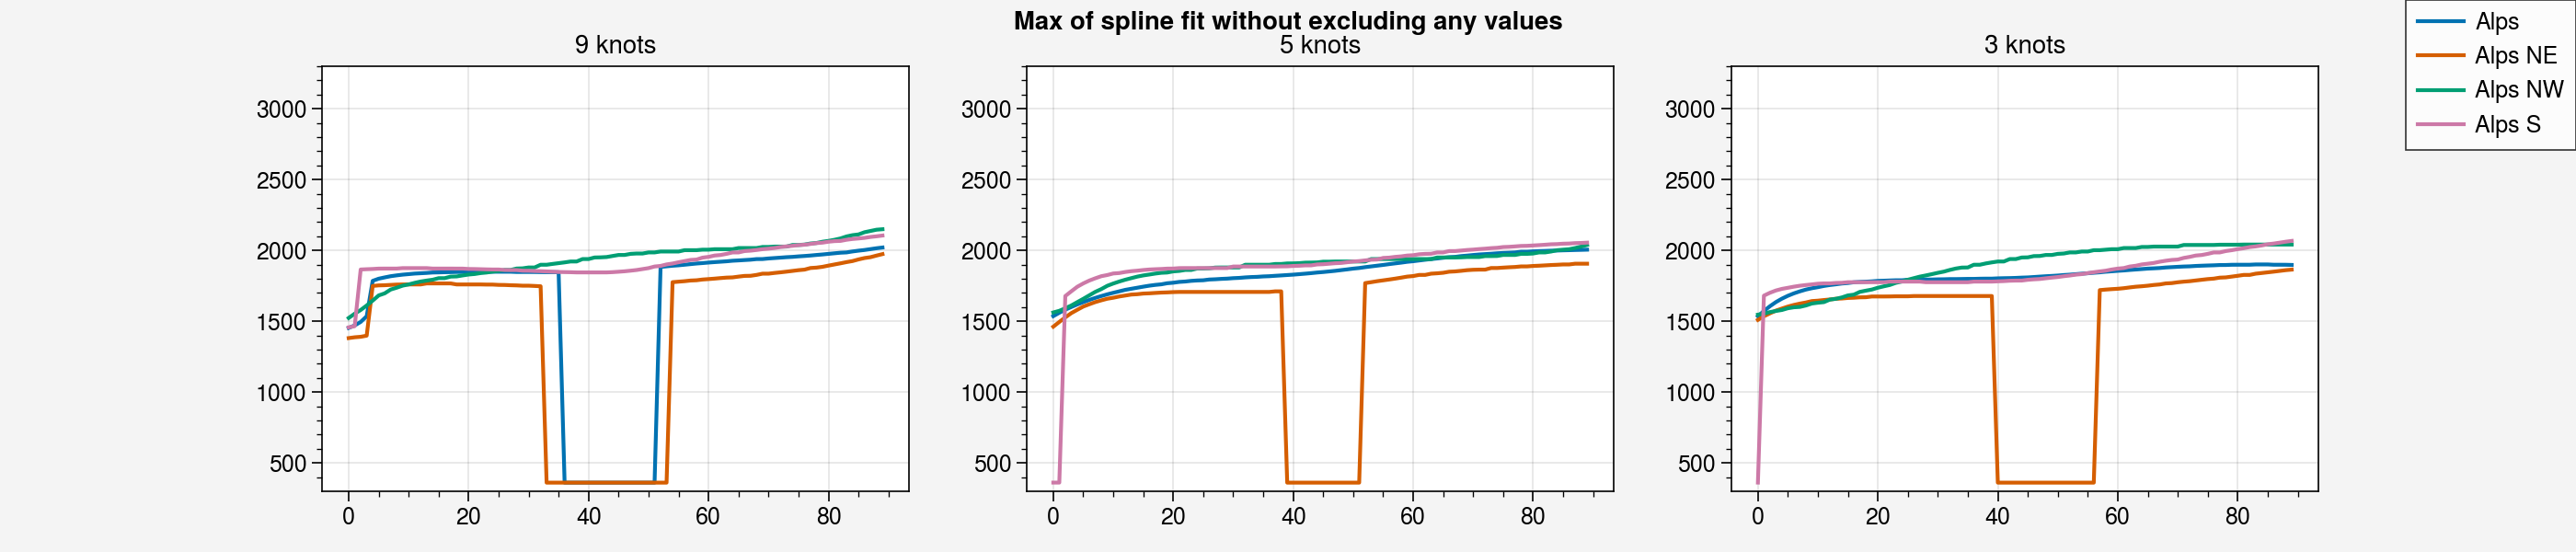

In [23]:
ig, ax = plt.subplots(ncols=3, figsize=(14, 3))

for i in range(4):
    ax[0].plot(height_max_k9_MAM_norestrict[i],label=names_regions[i])
    ax[0].set_ylim([300,3300])
    ax[1].plot(height_max_k5_MAM_norestrict[i])
    ax[1].set_ylim([300,3300])
    ax[2].plot(height_max_k3_MAM_norestrict[i])
    ax[2].set_ylim([300,3300])

ig.legend()
ig.suptitle('Max of spline fit without excluding any values')
ax[0].set_title('9 knots')
ax[1].set_title('5 knots')
ax[2].set_title('3 knots')

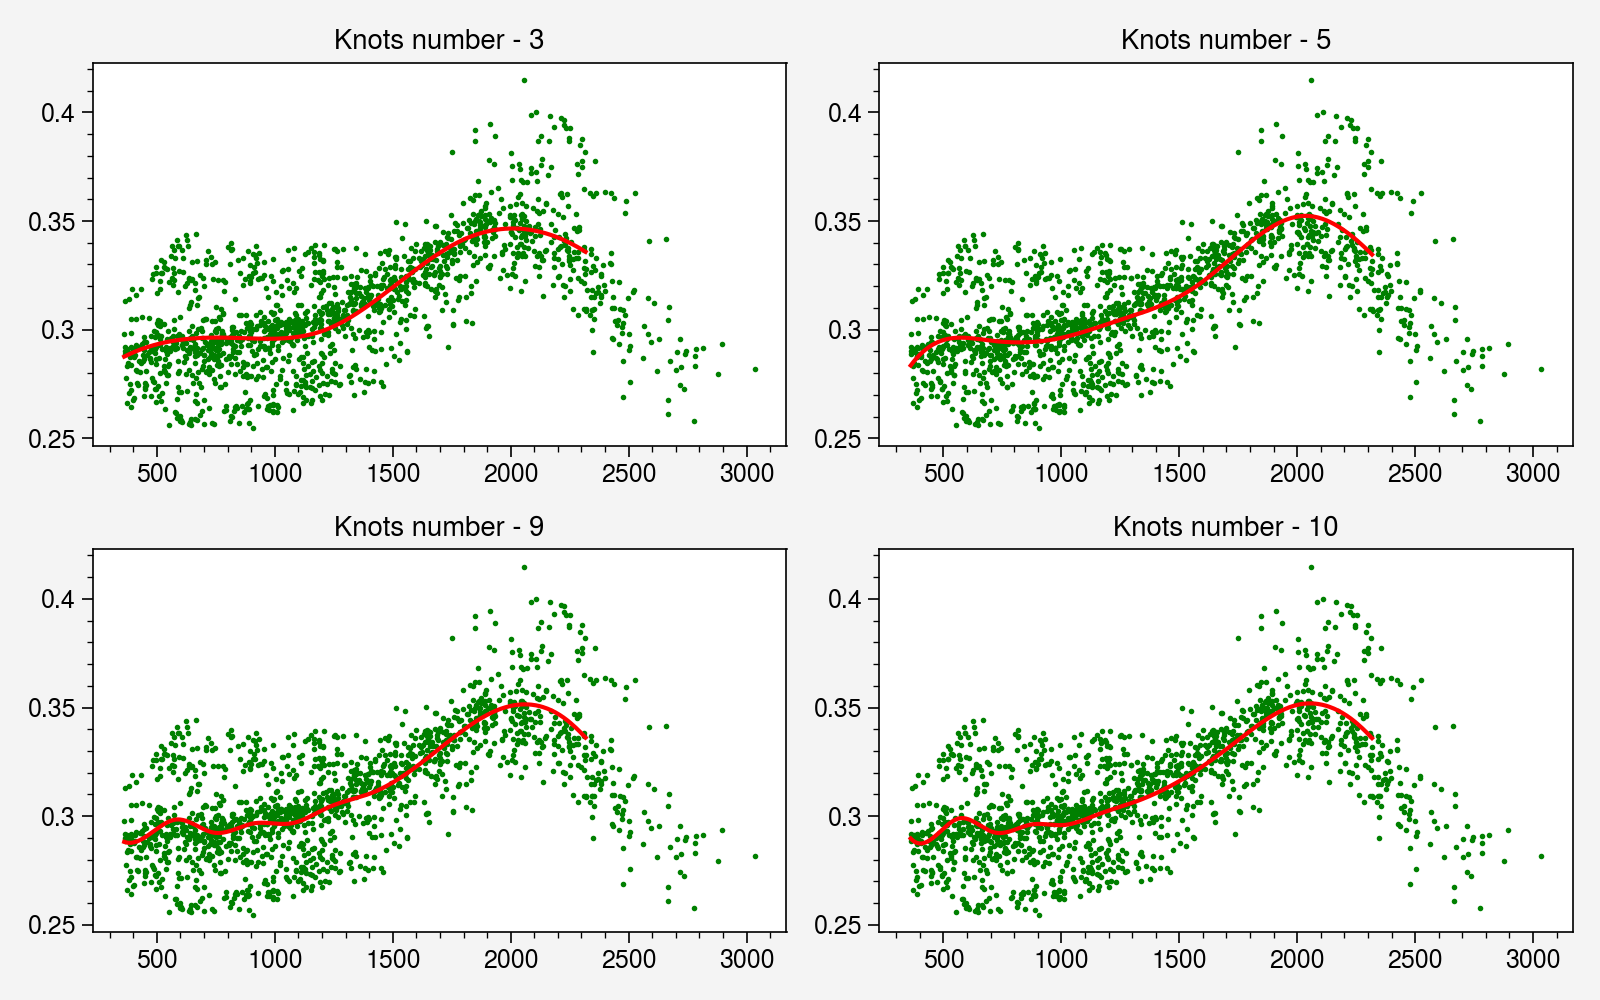

In [24]:
i=80

height = np.ma.masked_array(ds.SH[jmin:jmax,imin:imax], mask=np.invert(region_masks[3]))
vec_height = height[height.mask == False]

slope_T_MAM = 10*np.ma.masked_array(slope_T_periods[i,1], mask=np.invert(region_masks[3]))
vec_slope_T_MAM = slope_T_MAM[slope_T_MAM.mask == False]
        
vec_height_srt = [y for (y,x) in sorted(zip(vec_height,vec_slope_T_MAM), key=lambda pair: pair[0])]
vec_slope_T_MAM_srt = [x for (y,x) in sorted(zip(vec_height,vec_slope_T_MAM), key=lambda pair: pair[0])]


knots = [3, 5, 9, 10]
j=0

ig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 5))

for row in range(2):
    for col in range(2):
        ax[row][col].plot(vec_height_srt, vec_slope_T_MAM_srt, '.',c="g", markersize=2)
        yfit = spline(knots[j],vec_height_srt, vec_slope_T_MAM_srt)
        ax[row][col].plot(vec_height_srt[:-100], yfit[:-100], 'r')
        ax[row][col].set_title("Knots number - "+str(knots[j]))
        ax[row][col].grid()
        j=j+1
        
plt.tight_layout()        
plt.show()

In [25]:
mean1_snowline = np.load('/bettik/castelli/data/saved_data_MAR_ECEarth3/daily_snowline_minmaxaverage_alpsregions_mean1pix.npy')

In [26]:
mean10_snowline = np.load('/bettik/castelli/data/saved_data_MAR_ECEarth3/daily_snowline_minmaxaverage_alpsregions_mean10pix.npy')

In [27]:
mean1_minH_snow_seas = np.full((4,140,4),np.nan)
mean1_maxH_nosnow_seas = np.full((4,140,4),np.nan)
mean1_average_minmax_snow_seas = np.full((4,140,4),np.nan)

mean1_snowline_seas = [mean1_minH_snow_seas,mean1_maxH_nosnow_seas,mean1_average_minmax_snow_seas]

for i in range(4):
    for j in range(3):
        
        mean1_snowline_seas[j][i,:,0] = np.median(np.concatenate((mean1_snowline[j][i,:,:59],mean1_snowline[j][i,:,334:365]),axis=1),axis=1)
        mean1_snowline_seas[j][i,:,1] = np.median(mean1_snowline[j][i,:,59:151],axis=1)
        mean1_snowline_seas[j][i,:,2] = np.median(mean1_snowline[j][i,:,151:243],axis=1)
        mean1_snowline_seas[j][i,:,3] = np.median(mean1_snowline[j][i,:,243:334],axis=1)

In [28]:
mean10_minH_snow_seas = np.full((4,140,4),np.nan)
mean10_maxH_nosnow_seas = np.full((4,140,4),np.nan)
mean10_average_minmax_snow_seas = np.full((4,140,4),np.nan)

mean10_snowline_seas = [mean10_minH_snow_seas,mean10_maxH_nosnow_seas,mean10_average_minmax_snow_seas]

for i in range(4):
    for j in range(3):
        
        mean10_snowline_seas[j][i,:,0] = np.median(np.concatenate((mean10_snowline[j][i,:,:59],mean10_snowline[j][i,:,334:365]),axis=1),axis=1)
        mean10_snowline_seas[j][i,:,1] = np.median(mean10_snowline[j][i,:,59:151],axis=1)
        mean10_snowline_seas[j][i,:,2] = np.median(mean10_snowline[j][i,:,151:243],axis=1)
        mean10_snowline_seas[j][i,:,3] = np.median(mean10_snowline[j][i,:,243:334],axis=1)

In [29]:
rollmean_50yrs_mean10_minH_snow_MAM = np.full((4,90),np.nan)
rollmean_50yrs_mean10_maxH_nosnow_MAM = np.full((4,90),np.nan)
rollmean_50yrs_mean10_average_minmax_snow_MAM = np.full((4,90),np.nan)

rollmean_50yrs_mean1_minH_snow_MAM = np.full((4,90),np.nan)
rollmean_50yrs_mean1_maxH_nosnow_MAM = np.full((4,90),np.nan)
rollmean_50yrs_mean1_average_minmax_snow_MAM = np.full((4,90),np.nan)

for j in range(4):
    for i in range(90):
        end = i+50
        rollmean_50yrs_mean10_minH_snow_MAM[j,i] = mean10_snowline_seas[0][j,i:end,1].mean()
        rollmean_50yrs_mean10_maxH_nosnow_MAM[j,i] = mean10_snowline_seas[1][j,i:end,1].mean()
        rollmean_50yrs_mean10_average_minmax_snow_MAM[j,i] = mean10_snowline_seas[2][j,i:end,1].mean()

        rollmean_50yrs_mean1_minH_snow_MAM[j,i] = mean1_snowline_seas[0][j,i:end,1].mean()
        rollmean_50yrs_mean1_maxH_nosnow_MAM[j,i] = mean1_snowline_seas[1][j,i:end,1].mean()
        rollmean_50yrs_mean1_average_minmax_snow_MAM[j,i] = mean1_snowline_seas[2][j,i:end,1].mean()

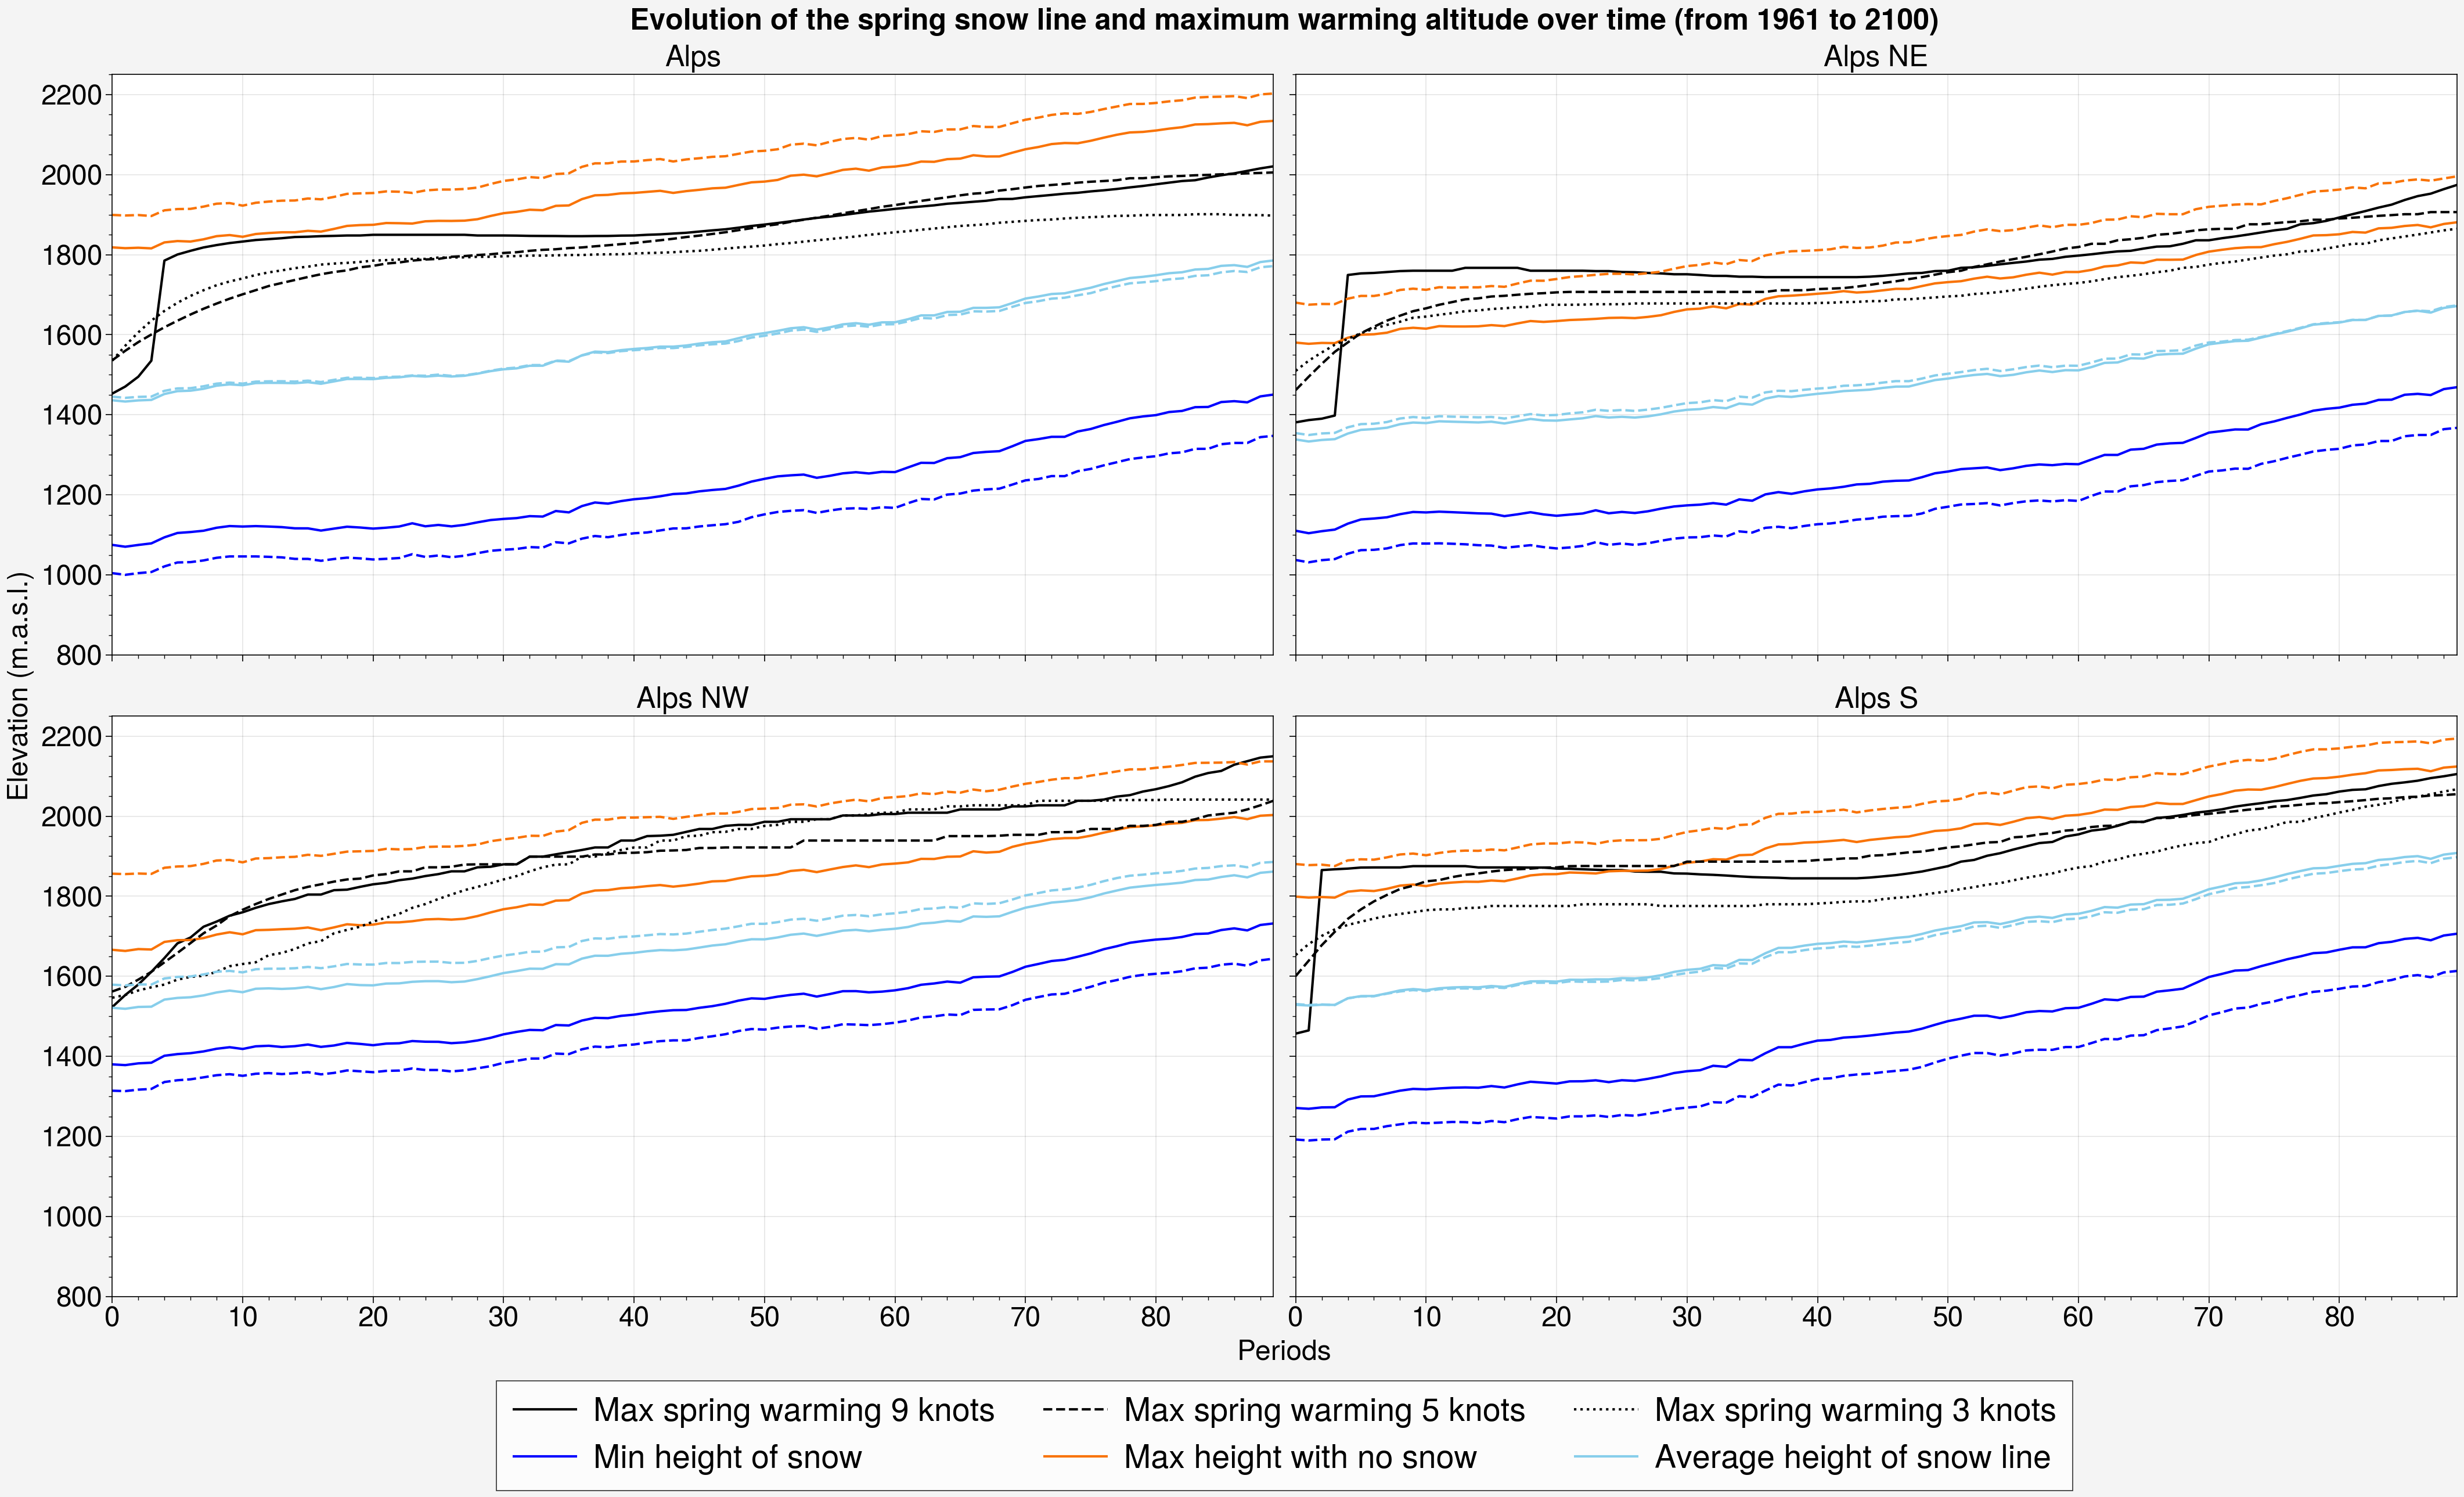

In [30]:
f,axs = pplt.subplots(nrows=2,ncols=2,axwidth=10,axheight=5)


axs[0].plot(height_max_k9_MAM[0],label='Max spring warming 9 knots',c='k')#,legend_kw={'fontsize':'30px'})
axs[0].plot(height_max_k5_MAM[0],linestyle='--',c='k',label='Max spring warming 5 knots')
axs[0].plot(height_max_k3_MAM[0],linestyle=':',c='k',label='Max spring warming 3 knots')
axs[0].plot(rollmean_50yrs_mean10_minH_snow_MAM[0],c='b',label='Min height of snow')
axs[0].plot(rollmean_50yrs_mean10_maxH_nosnow_MAM[0],c='orange',label='Max height with no snow')
axs[0].plot(rollmean_50yrs_mean10_average_minmax_snow_MAM[0],c='skyblue',label='Average height of snow line')

axs[0].plot(rollmean_50yrs_mean1_minH_snow_MAM[0],c='b',linestyle='--')
axs[0].plot(rollmean_50yrs_mean1_maxH_nosnow_MAM[0],c='orange',linestyle='--')
axs[0].plot(rollmean_50yrs_mean1_average_minmax_snow_MAM[0],c='skyblue',linestyle='--')
axs[0].format(title=names_regions[0],titlesize='25px')

for i in [1,2,3]:
    axs[i].plot(height_max_k9_MAM[i],c='k')
    axs[i].plot(rollmean_50yrs_mean10_minH_snow_MAM[i],c='b')
    axs[i].plot(rollmean_50yrs_mean10_maxH_nosnow_MAM[i],c='orange')
    axs[i].plot(rollmean_50yrs_mean10_average_minmax_snow_MAM[i],c='skyblue')

    axs[i].plot(height_max_k5_MAM[i],linestyle='--',c='k')
    axs[i].plot(height_max_k3_MAM[i],linestyle=':',c='k')
    axs[i].plot(rollmean_50yrs_mean1_minH_snow_MAM[i],c='b',linestyle='--')
    axs[i].plot(rollmean_50yrs_mean1_maxH_nosnow_MAM[i],c='orange',linestyle='--')
    axs[i].plot(rollmean_50yrs_mean1_average_minmax_snow_MAM[i],c='skyblue',linestyle='--')
    axs[i].format(title=names_regions[i],titlesize='25px')

#for i in range(4):
#    axs[i].legend()
f.legend(loc='b',prop = { "size": 20 })
axs.format(ylim=[800,2250],ylabel='Elevation (m.a.s.l.)',xlabel='Periods',fontsmallsize='24px',
           suptitle='Evolution of the spring snow line and maximum warming altitude over time (from 1961 to 2100)',suptitlesize='25px')